# Skip-gram Word2Vec

In this notebook, I'll lead you through using PyTorch to implement the [Word2Vec algorithm](https://en.wikipedia.org/wiki/Word2vec) using the skip-gram architecture. By implementing this, you'll learn about embedding words for use in natural language processing. This will come in handy when dealing with things like machine translation.

## Readings

Here are the resources I used to build this notebook. I suggest reading these either beforehand or while you're working on this material.

* A really good [conceptual overview](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) of Word2Vec from Chris McCormick 
* [First Word2Vec paper](https://arxiv.org/pdf/1301.3781.pdf) from Mikolov et al.
* [Neural Information Processing Systems, paper](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) with improvements for Word2Vec also from Mikolov et al.

---
## Word embeddings

When you're dealing with words in text, you end up with tens of thousands of word classes to analyze; one for each word in a vocabulary. Trying to one-hot encode these words is massively inefficient because most values in a one-hot vector will be set to zero. So, the matrix multiplication that happens in between a one-hot input vector and a first, hidden layer will result in mostly zero-valued hidden outputs.

To solve this problem and greatly increase the efficiency of our networks, we use what are called **embeddings**. Embeddings are just a fully connected layer like you've seen before. We call this layer the embedding layer and the weights are embedding weights. We skip the multiplication into the embedding layer by instead directly grabbing the hidden layer values from the weight matrix. We can do this because the multiplication of a one-hot encoded vector with a matrix returns the row of the matrix corresponding the index of the "on" input unit.

<img src='assets/lookup_matrix.png' width=50%>

Instead of doing the matrix multiplication, we use the weight matrix as a lookup table. We encode the words as integers, for example "heart" is encoded as 958, "mind" as 18094. Then to get hidden layer values for "heart", you just take the 958th row of the embedding matrix. This process is called an **embedding lookup** and the number of hidden units is the **embedding dimension**.
 
There is nothing magical going on here. The embedding lookup table is just a weight matrix. The embedding layer is just a hidden layer. The lookup is just a shortcut for the matrix multiplication. The lookup table is trained just like any weight matrix.

Embeddings aren't only used for words of course. You can use them for any model where you have a massive number of classes. A particular type of model called **Word2Vec** uses the embedding layer to find vector representations of words that contain semantic meaning.

---
## Word2Vec

The Word2Vec algorithm finds much more efficient representations by finding vectors that represent the words. These vectors also contain semantic information about the words.

<img src="assets/context_drink.png" width=40%>

Words that show up in similar **contexts**, such as "coffee", "tea", and "water" will have vectors near each other. Different words will be further away from one another, and relationships can be represented by distance in vector space.


There are two architectures for implementing Word2Vec:
>* CBOW (Continuous Bag-Of-Words) and 
* Skip-gram

<img src="assets/word2vec_architectures.png" width=60%>

In this implementation, we'll be using the **skip-gram architecture** with **negative sampling** because it performs better than CBOW and trains faster with negative sampling. Here, we pass in a word and try to predict the words surrounding it in the text. In this way, we can train the network to learn representations for words that show up in similar contexts.

---
## Loading Data

Next, we'll ask you to load in data and place it in the `data` directory

1. Load the [text8 dataset](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/October/5bbe6499_text8/text8.zip); a file of cleaned up *Wikipedia article text* from Matt Mahoney. 
2. Place that data in the `data` folder in the home directory.
3. Then you can extract it and delete the archive, zip file to save storage space.

After following these steps, you should have one file in your data directory: `data/text8`.

In [1]:
import pandas as pd
sz = pd.read_csv("E:\\Userhome\\mokuneva\\cleaned_sz.csv", encoding = 'utf-8', sep=';')

In [2]:
del sz['Unnamed: 0']

In [3]:
sz_texts = list(sz.texts)

In [4]:
from datetime import datetime
startTime = datetime.now()
import tokens

import multiprocessing as mp
NUM_CORE = mp.cpu_count()-8# set to the number of cores you want to use

import worker_preprocess

if __name__ == "__main__":
    list_of_objects = [tokens.tokens(i) for i in sz_texts]
    
    pool = mp.Pool(NUM_CORE)
    list_of_tokens = pool.map(worker_preprocess.worker_preprocess, ((obj) for obj in list_of_objects))
    pool.close()
    pool.join()

print(datetime.now() - startTime)

0:01:11.149946


## Pre-processing

Here I'm fixing up the text to make training easier. This comes from the `utils.py` file. The `preprocess` function does a few things:
>* It converts any punctuation into tokens, so a period is changed to ` <PERIOD> `. In this data set, there aren't any periods, but it will help in other NLP problems. 
* It removes all words that show up five or *fewer* times in the dataset. This will greatly reduce issues due to noise in the data and improve the quality of the vector representations. 
* It returns a list of words in the text.

This may take a few seconds to run, since our text file is quite large. If you want to write your own functions for this stuff, go for it!

In [5]:
import itertools
words = list(itertools.chain.from_iterable(list_of_tokens))

In [6]:
from collections import Counter
word_counts = Counter(words)
words = [word for word in words if word_counts[word] > 5]

In [7]:
print(words[:100])

['trotz', 'aller', 'friedensappelle', 'in', 'südafrika', 'terrorwelle', 'zur', 'jahres', 'wende', 'mord', 'an', 'in', 'kapstadt', 'gibt', 'rätsel', 'auf', 'kapstadt', 'apreuterafp', 'trotz', 'aller', 'friedensappelle', 'hat', 'das', 'neue', 'jahr', 'in', 'südafrika', 'mit', 'blutigen', 'gewalttaten', 'begonnen', 'fünf', 'maskierte', 'schwarze', 'töteten', 'in', 'der', 'silvesternacht', 'in', 'einem', 'pub', 'in', 'kapstadt', 'vier', 'weise', 'in', 'johannesburg', 'wurden', 'zwei', 'polizisten', 'erschossen', 'in', 'den', 'schwarzeinsiedlungen', 'tokio', 'und', 'katalonien', 'östlich', 'von', 'johannesburg', 'entdeckte', 'die', 'polizei', 'die', 'leichen', 'von', 'fünf', 'männern', 'und', 'einer', 'frau', 'die', 'meisten', 'der', 'opfer', 'seien', 'erschossen', 'worden', 'erklärte', 'die', 'polizei', 'bei', 'einem', 'weiteren', 'zwischenfall', 'in', 'der', 'nähe', 'der', 'hafenstadt', 'urban', 'seien', 'bei', 'der', 'von', 'ethnischen', 'indern', 'bewohnten', 'vorstadt', 'wortschwall']


In [8]:
# print some stats about this word data
print("Total words in text: {}".format(len(words)))
print("Unique words: {}".format(len(set(words)))) # `set` removes any duplicate words

Total words in text: 203863478
Unique words: 396697


### Dictionaries

Next, I'm creating two dictionaries to convert words to integers and back again (integers to words). This is again done with a function in the `utils.py` file. `create_lookup_tables` takes in a list of words in a text and returns two dictionaries.
>* The integers are assigned in descending frequency order, so the most frequent word ("the") is given the integer 0 and the next most frequent is 1, and so on. 

Once we have our dictionaries, the words are converted to integers and stored in the list `int_words`.

In [9]:
import utils

vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

print(int_words[:30])

[303, 336, 136068, 3, 3040, 53127, 58, 321, 2044, 2731, 22, 3, 10750, 98, 9600, 11, 10750, 81231, 303, 336, 136068, 27, 5, 94, 62, 3, 3040, 9, 6662, 7809]


## Subsampling

Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

> Implement subsampling for the words in `int_words`. That is, go through `int_words` and discard each word given the probablility $P(w_i)$ shown above. Note that $P(w_i)$ is the probability that a word is discarded. Assign the subsampled data to `train_words`.

In [10]:
from collections import Counter
import random
import numpy as np

threshold = 1e-5
word_counts = Counter(int_words)
#print(list(word_counts.items())[0])  # dictionary of int_words, how many times they appear

total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
# discard some frequent words, according to the subsampling equation
# create a new list of words for training
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

print(train_words[:30])

[303, 336, 136068, 53127, 2731, 10750, 9600, 10750, 81231, 303, 136068, 3040, 6662, 7809, 38947, 2029, 12982, 22703, 30535, 10750, 9893, 1202, 233147, 1178, 12033, 10820, 6, 9893, 11078, 740]


In [11]:
len(train_words)

66951443

## Making batches

Now that our data is in good shape, we need to get it into the proper form to pass it into our network. With the skip-gram architecture, for each word in the text, we want to define a surrounding _context_ and grab all the words in a window around that word, with size $C$. 

From [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf): 

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $[ 1: C ]$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."

> **Exercise:** Implement a function `get_target` that receives a list of words, an index, and a window size, then returns a list of words in the window around the index. Make sure to use the algorithm described above, where you chose a random number of words to from the window.

Say, we have an input and we're interested in the idx=2 token, `741`: 
```
[5233, 58, 741, 10571, 27349, 0, 15067, 58112, 3580, 58, 10712]
```

For `R=2`, `get_target` should return a list of four values:
```
[5233, 58, 10571, 27349]
```

In [12]:
def get_target(words, idx, window_size=10):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = words[start:idx] + words[idx+1:stop+1]
    
    return list(target_words)

In [13]:
# test your code!

# run this cell multiple times to check for random window selection
int_text = [i for i in range(10)]
print('Input: ', int_text)
idx=5 # word index of interest

target = get_target(int_text, idx=idx, window_size=5)
print('Target: ', target)  # you should get some indices around the idx

Input:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Target:  [0, 1, 2, 3, 4, 6, 7, 8, 9]


### Generating Batches 

Here's a generator function that returns batches of input and target data for our model, using the `get_target` function from above. The idea is that it grabs `batch_size` words from a words list. Then for each of those batches, it gets the target words in a window.

In [14]:
def get_batches(words, batch_size, window_size=10):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

In [15]:
int_text = [i for i in range(20)]
x,y = next(get_batches(int_text, batch_size=4, window_size=10))

print('x\n', x)
print('y\n', y)

x
 [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3]
y
 [1, 2, 3, 0, 2, 3, 0, 1, 3, 0, 1, 2]


---
## Validation

Here, I'm creating a function that will help us observe our model as it learns. We're going to choose a few common words and few uncommon words. Then, we'll print out the closest words to them using the cosine similarity: 

<img src="assets/two_vectors.png" width=30%>

$$
\mathrm{similarity} = \cos(\theta) = \frac{\vec{a} \cdot \vec{b}}{|\vec{a}||\vec{b}|}
$$


We can encode the validation words as vectors $\vec{a}$ using the embedding table, then calculate the similarity with each word vector $\vec{b}$ in the embedding table. With the similarities, we can print out the validation words and words in our embedding table semantically similar to those words. It's a nice way to check that our embedding table is grouping together words with similar semantic meanings.

In [16]:
def cosine_similarity(embedding, valid_size=16, valid_window=100, device='cpu'):
    """ Returns the cosine similarity of validation words with words in the embedding matrix.
        Here, embedding should be a PyTorch embedding module.
    """
    
    # Here we're calculating the cosine similarity between some random words and 
    # our embedding vectors. With the similarities, we can look at what words are
    # close to our random words.
    
    # sim = (a . b) / |a||b|
    
    embed_vectors = embedding.weight
    
    # magnitude of embedding vectors, |b|
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    
    # pick N words from our ranges (0,window) and (1000,1000+window). lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples,
                               random.sample(range(1000,1000+valid_window), valid_size//2))
    valid_examples = torch.LongTensor(valid_examples).to(device)
    
    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_vectors.t())/magnitudes
        
    return valid_examples, similarities

---
# SkipGram model

Define and train the SkipGram model. 
> You'll need to define an [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) and a final, softmax output layer.

An Embedding layer takes in a number of inputs, importantly:
* **num_embeddings** – the size of the dictionary of embeddings, or how many rows you'll want in the embedding weight matrix
* **embedding_dim** – the size of each embedding vector; the embedding dimension

Below is an approximate diagram of the general structure of our network.
<img src="assets/skip_gram_arch.png" width=60%>

>* The input words are passed in as batches of input word tokens. 
* This will go into a hidden layer of linear units (our embedding layer). 
* Then, finally into a softmax output layer. 

We'll use the softmax layer to make a prediction about the context words by sampling, as usual.

---
## Negative Sampling

For every example we give the network, we train it using the output from the softmax layer. That means for each input, we're making very small changes to millions of weights even though we only have one true example. This makes training the network very inefficient. We can approximate the loss from the softmax layer by only updating a small subset of all the weights at once. We'll update the weights for the correct example, but only a small number of incorrect, or noise, examples. This is called ["negative sampling"](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). 

There are two modifications we need to make. First, since we're not taking the softmax output over all the words, we're really only concerned with one output word at a time. Similar to how we use an embedding table to map the input word to the hidden layer, we can now use another embedding table to map the hidden layer to the output word. Now we have two embedding layers, one for input words and one for output words. Secondly, we use a modified loss function where we only care about the true example and a small subset of noise examples.

$$
- \large \log{\sigma\left(u_{w_O}\hspace{0.001em}^\top v_{w_I}\right)} -
\sum_i^N \mathbb{E}_{w_i \sim P_n(w)}\log{\sigma\left(-u_{w_i}\hspace{0.001em}^\top v_{w_I}\right)}
$$

This is a little complicated so I'll go through it bit by bit. $u_{w_O}\hspace{0.001em}^\top$ is the embedding vector for our "output" target word (transposed, that's the $^\top$ symbol) and $v_{w_I}$ is the embedding vector for the "input" word. Then the first term 

$$\large \log{\sigma\left(u_{w_O}\hspace{0.001em}^\top v_{w_I}\right)}$$

says we take the log-sigmoid of the inner product of the output word vector and the input word vector. Now the second term, let's first look at 

$$\large \sum_i^N \mathbb{E}_{w_i \sim P_n(w)}$$ 

This means we're going to take a sum over words $w_i$ drawn from a noise distribution $w_i \sim P_n(w)$. The noise distribution is basically our vocabulary of words that aren't in the context of our input word. In effect, we can randomly sample words from our vocabulary to get these words. $P_n(w)$ is an arbitrary probability distribution though, which means we get to decide how to weight the words that we're sampling. This could be a uniform distribution, where we sample all words with equal probability. Or it could be according to the frequency that each word shows up in our text corpus, the unigram distribution $U(w)$. The authors found the best distribution to be $U(w)^{3/4}$, empirically. 

Finally, in 

$$\large \log{\sigma\left(-u_{w_i}\hspace{0.001em}^\top v_{w_I}\right)},$$ 

we take the log-sigmoid of the negated inner product of a noise vector with the input vector. 

<img src="assets/neg_sampling_loss.png" width=50%>

To give you an intuition for what we're doing here, remember that the sigmoid function returns a probability between 0 and 1. The first term in the loss pushes the probability that our network will predict the correct word $w_O$ towards 1. In the second term, since we are negating the sigmoid input, we're pushing the probabilities of the noise words towards 0.

In [18]:
import torch
from torch import nn
import torch.optim as optim

In [19]:
class SkipGramNeg(nn.Module):
    def __init__(self, n_vocab, n_embed, noise_dist=None):
        super().__init__()
        
        self.n_vocab = n_vocab
        self.n_embed = n_embed
        self.noise_dist = noise_dist
        
        # define embedding layers for input and output words
        self.in_embed = nn.Embedding(n_vocab, n_embed)
        self.out_embed = nn.Embedding(n_vocab, n_embed)
        
        # Initialize embedding tables with uniform distribution
        # I believe this helps with convergence
        self.in_embed.weight.data.uniform_(-1, 1)
        self.out_embed.weight.data.uniform_(-1, 1)
        
    def forward_input(self, input_words):
        input_vectors = self.in_embed(input_words)
        return input_vectors
    
    def forward_output(self, output_words):
        output_vectors = self.out_embed(output_words)
        return output_vectors
    
    def forward_noise(self, batch_size, n_samples):
        """ Generate noise vectors with shape (batch_size, n_samples, n_embed)"""
        if self.noise_dist is None:
            # Sample words uniformly
            noise_dist = torch.ones(self.n_vocab)
        else:
            noise_dist = self.noise_dist
            
        # Sample words from our noise distribution
        noise_words = torch.multinomial(noise_dist,
                                        batch_size * n_samples,
                                        replacement=True)
        
        device = "cuda" if model.out_embed.weight.is_cuda else "cpu"
        noise_words = noise_words.to(device)
        
        noise_vectors = self.out_embed(noise_words).view(batch_size, n_samples, self.n_embed)
        
        return noise_vectors

In [20]:
class NegativeSamplingLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input_vectors, output_vectors, noise_vectors):
        
        batch_size, embed_size = input_vectors.shape
        
        # Input vectors should be a batch of column vectors
        input_vectors = input_vectors.view(batch_size, embed_size, 1)
        
        # Output vectors should be a batch of row vectors
        output_vectors = output_vectors.view(batch_size, 1, embed_size)
        
        # bmm = batch matrix multiplication
        # correct log-sigmoid loss
        out_loss = torch.bmm(output_vectors, input_vectors).sigmoid().log()
        out_loss = out_loss.squeeze()
        
        # incorrect log-sigmoid loss
        noise_loss = torch.bmm(noise_vectors.neg(), input_vectors).sigmoid().log()
        noise_loss = noise_loss.squeeze().sum(1)  # sum the losses over the sample of noise vectors

        # negate and sum correct and noisy log-sigmoid losses
        # return average batch loss
        return -(out_loss + noise_loss).mean()

### Training

Below is our training loop, and I recommend that you train on GPU, if available.

In [21]:
from datetime import datetime
startTime = datetime.now() # track time

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Get our noise distribution
# Using word frequencies calculated earlier in the notebook
word_freqs = np.array(sorted(freqs.values(), reverse=True))
unigram_dist = word_freqs/word_freqs.sum()
noise_dist = torch.from_numpy(unigram_dist**(0.75)/np.sum(unigram_dist**(0.75)))

# instantiating the model
embedding_dim = 256
model = SkipGramNeg(len(vocab_to_int), embedding_dim, noise_dist=noise_dist).to(device)

# using the loss that we defined
criterion = NegativeSamplingLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.0001)

print_every = 10000
steps = 0
epochs = 25

# train for some number of epochs
for e in range(epochs):
    
    # get our input, target batches
    for input_words, target_words in get_batches(train_words, 128):
        steps += 1
        inputs, targets = torch.LongTensor(input_words), torch.LongTensor(target_words)
        inputs, targets = inputs.to(device), targets.to(device)
        
        # input, output, and noise vectors
        input_vectors = model.forward_input(inputs)
        output_vectors = model.forward_output(targets)
        noise_vectors = model.forward_noise(inputs.shape[0], 5)

        # negative sampling loss
        loss = criterion(input_vectors, output_vectors, noise_vectors)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss stats
        if steps % print_every == 0:
            print("Epoch: {}/{}".format(e+1, epochs))
            print("Loss: ", loss.item()) # avg batch loss at this point in training
            valid_examples, valid_similarities = cosine_similarity(model.in_embed, device=device)
            _, closest_idxs = valid_similarities.topk(6)

            valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
            for ii, valid_idx in enumerate(valid_examples):
                closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
                print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
            print("...\n")

Epoch: 1/25
Loss:  12.586276054382324
sein | hochheiligen, zweistufigen, optimist, wirtschaftsstark, daisy
einer | nehms, angefixt, usbanschluss, hochspekulativen, reisfeld
die | nullen, agentenfilmen, sozialträgern, baugeräten, narváez
neue | keitel, impfkampagnen, kommanditisten, dreigeteilten, forsell
doch | fntr, privatkino, ausdehnt, gesessen, regionalwirtschaftlichen
auch | marios, annechristin, sanitärindustrie, desertierte, generikum
es | phantasialand, artillerieraketen, epstein, wollt, hauptschuldiger
sich | karmasin, hüfte, vorbeugehaft, laserdisplaytechnik, sporleder
geschäftsführer | schifffahrtsrouten, agrochemiegeschäft, wahrnehmungsstörung, reaktorblöcken, kirchenbank
ermittlungen | benutzern, gewinnvortrages, kundenmonitor, geldhändler, klattens
amerika | schlafstatt, beanstande, myrdal, zurückzog, pflanzenanbau
richtung | stahlkonzern, vorgängerregierungen, betreuungsunterhalt, indexierte, melvill
begonnen | nordfranzösische, ipil, unexperten, bonitätsklassen, stammti

Epoch: 1/25
Loss:  6.976571559906006
dm | die, der, und, in, den
war | der, die, von, und, des
und | der, die, in, den, von
haben | und, die, der, im, in
wurde | die, der, des, und, in
nicht | die, der, und, auf, in
vor | die, von, den, der, in
unternehmen | die, und, der, dm, sich
republik | dm, kursavancen, erreger, feingefühl, eine
einzige | atomkompromisses, rauchende, gle, verkünden, istanbulmoskau
a | prabhakaran, missbrauchbar, das, dm, citibank
alter | freigebig, döhnert, direktwahlkreise, gegen, kompromissloser
richtung | stahlkonzern, vorgängerregierungen, pesa, indexierte, gewann
fällen | bericht, sich, stipendienprogramm, weltgrößten, neutrino
sozialdemokraten | vollem, sparpaket, hornbach, stärker, fernsehproduktionsfirma
forderungen | eine, vertraut, die, ausstehe, und
...

Epoch: 1/25
Loss:  6.634851932525635
man | in, und, der, die, im
einem | und, der, auf, die, den
im | die, in, der, und, von
sie | den, in, und, der, die
war | der, von, und, die, den
wenn | im, die, i

Epoch: 1/25
Loss:  3.5950698852539062
diese | die, der, hat, und, nicht
bei | der, die, auf, nach, von
vor | und, der, von, die, dem
den | der, und, die, für, hat
sein | einer, die, nicht, der, eine
keine | den, der, die, und, eine
über | zu, und, der, eine, die
um | auf, bei, im, von, am
mehreren | einen, sowie, jedoch, selbst, seine
fällt | davon, wieder, es, im, allem
häufig | rund, unternehmen, milliarden, darüber, weiter
müller | wieder, wenn, jahre, wie, keine
jährigen | seine, über, zwei, und, das
geschäftsführer | wurde, das, deutschland, als, allem
private | gegen, werden, sie, brüssel, zur
anbieter | rund, sowie, am, nach, auf
...

Epoch: 1/25
Loss:  3.833362579345703
so | die, und, zu, sie, es
jahren | den, zu, die, und, aus
für | und, die, der, als, den
kann | einer, die, nicht, zu, auch
gibt | der, aus, es, auch, einer
an | der, und, den, die, sich
werden | und, für, auch, der, die
prozent | um, auf, millionen, milliarden, rund
möglichkeit | zwei, daß, es, mehr, eine
gesch

Epoch: 1/25
Loss:  3.8301570415496826
wieder | im, das, einen, mit, die
bis | etwa, auf, mehr, damit, von
jahr | vergangenen, um, bis, etwa, zehn
nicht | zu, sie, es, ist, dass
gibt | nur, es, sie, wird, auch
immer | es, nicht, ist, dass, sind
und | der, den, in, das, ist
am | nach, hatte, an, in, der
gefunden | daß, alle, durch, habe, dazu
schulden | insgesamt, knapp, euro, unternehmen, milliarden
gefallen | kurs, woche, weiter, bis, um
rahmen | diese, keine, würden, können, anderem
einschätzung | zehn, allem, damit, allerdings, sechs
strategie | dass, jahren, den, wie, wird
geschlossen | deutsche, europäischen, daß, waren, um
diskussion | müsse, nicht, immer, er, kann
...

Epoch: 1/25
Loss:  3.8818156719207764
gibt | wird, nur, nicht, sie, zu
sagte | und, nicht, sei, zu, sein
von | den, an, auf, bei, die
einem | den, der, im, mit, die
unter | im, den, von, als, mit
gegen | er, wurde, regierung, habe, seiner
der | den, die, und, auch, für
werde | auch, die, der, für, zu
glaubt | könnt

Epoch: 1/25
Loss:  3.0578558444976807
einen | und, der, den, die, ein
hatte | des, war, vor, der, am
sein | es, hat, und, sich, nicht
er | ihm, ihn, seine, war, seiner
wenn | kann, aber, nicht, sie, es
des | der, in, den, ein, dem
nur | auch, ist, das, es, und
wieder | ein, der, die, den, und
lieber | heute, sagt, man, ist, sie
hannover | dpa, münchen, heißt, den, statt
trump | stromtochter, sellge, veganz, werbekaufmann, unultimatum
wiederum | es, auch, nur, weil, jetzt
schaden | sogar, es, aus, allerdings, so
titel | aktien, papiere, analysten, plus, börse
anbieter | kunden, unternehmen, branche, markt, firmen
jährigen | jahre, ihn, habe, jährige, gewesen
...

Epoch: 1/25
Loss:  2.980597734451294
jahren | fast, bei, mehr, etwa, um
nur | auch, ist, das, und, wie
bis | bei, fast, um, jahr, etwa
nicht | sie, ist, es, aber, dass
im | von, der, die, den, in
ihre | und, das, die, ist, eine
als | ein, und, der, in, das
einen | und, das, ein, den, die
mitteilte | knapp, lag, rund, prozent, e

Epoch: 2/25
Loss:  3.2061965465545654
unternehmen | branche, anteil, zahlen, bereich, millionen
wird | das, für, auch, und, durch
nur | auch, das, für, aber, wird
soll | für, wird, das, und, neue
nun | dass, ist, als, ohne, jetzt
im | von, mit, bei, auf, weiter
er | seine, seinem, dessen, seiner, rede
jahr | millionen, erhöht, insgesamt, zahlen, um
nacht | stadt, hauptstadt, soldaten, armee, polizei
konzerns | konzern, ag, unternehmens, umsatz, vorstandschef
papier | neuen, dieses, das, wird, so
zustimmung | beschlossen, entscheiden, bundesregierung, entscheidung, betonte
wichtige | zu, die, ihre, auch, sowohl
geschäftsjahr | umsatz, gewinn, konzern, vorjahr, verlust
personen | angaben, wurden, zwei, mindestens, zufolge
lieber | natürlich, uns, alles, was, einfach
...

Epoch: 2/25
Loss:  2.916388988494873
dm | millionen, vorjahr, umsatz, milliarden, verlust
aus | dem, und, ein, in, den
jahr | erhöht, insgesamt, zahlen, rund, millionen
etwa | bis, zehn, rund, insgesamt, jahr
oder | gibt

Epoch: 2/25
Loss:  2.9627983570098877
jahr | laufenden, erhöht, rechnet, zahlen, milliarden
eine | zu, zur, einer, ihrer, über
keine | daß, eine, dass, nicht, dazu
kann | wenn, sondern, man, welche, muss
unter | einem, nach, von, auf, seit
und | ein, aus, dem, als, in
am | dienstag, freitag, donnerstag, montag, mittwoch
einer | des, der, über, dem, in
general | amerikanische, britischen, amerikanischen, berichtete, darunter
putin | wladimir, jelzin, moskau, besuch, beziehungen
reformen | einig, müsse, union, wirtschaftspolitik, politik
gewinne | euro, wert, markt, kräftig, prozent
schreiben | steht, hat, erst, auch, stehen
fischer | minister, forderte, ministerpräsident, kabinett, debatte
bedeutung | daß, aber, probleme, nicht, auch
gefallen | stand, sagten, führten, um, gab
...

Epoch: 2/25
Loss:  2.7084455490112305
nur | auch, so, aber, diese, wie
mehr | noch, nur, dabei, auch, für
ihre | die, und, zu, ein, auch
gibt | auch, wie, so, aber, ist
so | ist, wie, nur, aber, da
immer | so,

Epoch: 2/25
Loss:  3.309755563735962
was | gar, man, wirklich, sagen, alles
keine | eine, dass, ohne, zu, könne
bis | jahres, bei, damit, von, fünf
zur | eine, zu, keine, könne, bezeichnete
millionen | rund, milliarden, verlust, dm, umsatz
prozent | plus, stiegen, minus, gestiegen, kräftig
ein | und, den, aus, als, hat
deutschen | bei, beim, deutsche, legt, diesem
überraschend | nachdem, zuvor, gab, enttäuscht, spekulationen
geschäftsjahr | umsatz, gewinn, gesteigert, verlust, operativen
glaubt | eher, sehr, gerade, viel, wenig
trump | stromtochter, inquisitorisch, sellge, gus, dpaafp
konzerns | konzern, vorstandschef, unternehmens, verkauf, übernahme
geschlossen | auf, gab, nachdem, ebenfalls, nach
übernommen | übernimmt, tochter, übernahme, sitz, übernehmen
geschäftsführer | vorstandsmitglied, werner, stuttgarter, vorstand, geschäftsführung
...

Epoch: 2/25
Loss:  2.9163460731506348
deutschland | allem, mehr, insbesondere, davon, deutschlands
an | mit, der, einen, zum, den
vor | der,

Epoch: 2/25
Loss:  2.8727951049804688
an | mit, der, den, einen, die
über | eine, die, nun, einer, der
vor | den, der, einer, in, nach
einen | an, mit, den, der, erst
keine | dass, alle, nicht, ohne, sollte
man | was, alles, warum, natürlich, ganz
will | neuen, für, neue, spätestens, wird
es | nicht, ist, aber, auch, weil
wächst | wachsende, allem, wachsenden, dramatisch, zunehmend
nahe | nacht, nähe, ums, gekommen, feuer
verlag | firma, münchner, tochter, gmbh, gegründete
alter | kindern, kind, kinder, frauen, junge
papier | dagegen, ab, bewertung, aktuellen, legt
handelt | regelmäßig, deren, denen, haben, solcher
nächste | könnte, wird, hoffen, würde, zwar
einschätzung | rechnen, experten, erwarten, auswirkungen, dürften
...

Epoch: 2/25
Loss:  3.0022988319396973
mehr | allein, sind, besonders, allem, liegt
sei | zur, erklärt, keine, über, einer
haben | und, ein, sich, das, die
vom | der, dem, zum, ein, den
den | die, der, mit, an, und
wieder | noch, auf, den, um, als
am | montag, wo

Epoch: 2/25
Loss:  3.0965325832366943
mit | an, einen, den, aus, ein
was | man, wirklich, gar, natürlich, da
schon | lange, ist, doch, ein, wie
jahren | fast, drei, bei, inzwischen, vier
soll | bisher, bislang, werden, sollen, einigen
nun | über, hat, der, erst, dem
hatte | wochen, am, november, februar, offenbar
sei | zur, erklärt, weder, keine, über
gewinne | verluste, wert, kräftig, rendite, investoren
müller | peter, jürgen, christian, matthias, bayerischen
sozialdemokraten | koalitionspartner, christdemokraten, liberalen, fraktion, parteitag
lufthansa | fluggesellschaft, air, fluggesellschaften, airlines, airline
syrien | irak, truppen, armee, libanon, angriffe
möglichkeit | müssten, sollten, möglich, grundsätzlich, verlangen
diskussion | thema, halte, diskutiert, einig, müsse
suchen | finden, gibt, andere, anderen, sondern
...

Epoch: 2/25
Loss:  2.773907423019409
wenn | kann, gar, aber, wirklich, tun
mit | an, einen, den, aus, ein
vor | der, einer, in, den, im
aus | in, mit, den

Epoch: 3/25
Loss:  2.706343412399292
unter | einem, nach, mit, an, dem
aus | in, ein, dem, den, und
dm | verlust, gewinn, halbjahr, millionen, erhöhte
jahr | gesamten, insgesamt, hälfte, erhöht, rechnet
noch | wird, das, auch, damit, dieses
können | müssen, oder, wären, gibt, diese
doch | schon, sehen, ganz, da, einmal
um | auf, weiter, erreicht, jahres, bis
hannover | stuttgart, hamburg, düsseldorf, stuttgarter, köln
versuchen | unmöglich, sprechen, sie, suchen, gegenseitig
wichtige | wichtigen, ziel, bringen, folgen, einigen
nacht | ums, nähe, gekommen, stadt, angriff
fällt | etwas, zeigt, sogar, immerhin, kaum
entwickelt | konzentriert, technologie, bietet, liefert, konkurrenz
übernommen | übernimmt, gmbh, tochter, gehörenden, münchen
gewinne | kräftig, rendite, profitiert, niedriger, anleger
...

Epoch: 3/25
Loss:  2.778029441833496
nicht | es, daß, kein, dass, lassen
unter | einem, nach, mit, dem, an
damit | für, allerdings, noch, bisher, dieses
seine | seiner, dessen, er, seinem,

Epoch: 3/25
Loss:  3.0762672424316406
er | seiner, seine, seinem, ihm, gesagt
etwa | zehn, großteil, million, fünf, zwölf
habe | gegeben, gewesen, erklärt, einer, des
eines | dem, einer, erklärt, in, gesetzt
einem | nach, unter, einen, im, mit
jahr | rechnet, erhöht, gesamten, laufenden, hälfte
wird | stellt, auch, jetzt, für, dieser
deutschland | allem, sieht, durch, allein, gleichzeitig
trump | clinton, clintons, uspräsidenten, obama, bill
schreiben | gemacht, erst, keine, wird, nun
gemeinsame | gemeinsamen, gemeinsames, zusammenarbeit, lösung, unterstrich
bundeswehr | einsatz, truppe, scharping, einsätze, einzusetzen
bestätigt | gegeben, habe, hatte, erklärt, stellte
mitteilte | angaben, teilte, zufolge, august, elf
marke | markt, kräftig, geschäft, verkaufte, verkauften
private | privaten, privater, kosten, beispielsweise, zusätzlich
...

Epoch: 3/25
Loss:  2.6832618713378906
dm | millionen, betrage, erwirtschaftet, ertrag, beziffert
ihre | zu, die, ihren, und, anderen
hatte | am, 

Epoch: 3/25
Loss:  3.272453546524048
immer | vielen, gerade, lässt, längst, ganze
prozent | plus, jahresbeginn, stiegen, minus, verbesserten
gegen | wirft, vorgeworfen, wiederholt, umgehend, umstrittenen
wieder | letzten, bricht, den, obwohl, sich
nach | einem, unter, im, des, der
millionen | rund, beziffert, verdoppelt, bezifferte, milliarden
dm | euro, betrage, millionen, beziffert, betragen
vom | der, ein, einer, aus, dem
entwickelt | konzentriert, konkurrenz, schneller, größe, klassischen
nahe | nähe, gekommen, nacht, feuer, begannen
möglichkeit | möglich, grundsätzlich, unabhängig, sollten, verlangen
anbieter | kunden, anbietern, service, produkte, wettbewerber
jährigen | war, wurde, jährige, gestanden, kam
wächst | allem, wachsenden, wachsende, stark, voraus
laufenden | laufende, rechnet, jahresende, halbjahr, erzielt
nationen | vereinten, un, humanitäre, staatengemeinschaft, ungeneralsekretär
...

Epoch: 3/25
Loss:  2.8454267978668213
neue | neuen, setzt, bringen, neues, sieht
d

Epoch: 3/25
Loss:  3.1216366291046143
können | müssen, nur, oder, gibt, nutzen
doch | ist, lange, zeit, einmal, schon
dem | hat, der, den, in, mit
euro | dm, milliarden, milliarde, betragen, zahlen
über | eine, zu, einer, nun, sich
prozent | plus, jahresbeginn, vergleich, stiegen, jahresanfang
das | auch, wie, geht, wird, ein
ist | aber, wie, es, so, doch
kilometer | kilometern, errichtet, gebäude, entlang, lastwagen
her | heute, gerade, vorbei, ganz, kleinen
wächst | allem, wachsende, voraus, spüren, wachsenden
a | bestellt, airbus, bestellung, baut, maschinen
glaubt | meint, zeiten, eher, sehr, kaum
nahe | nähe, nacht, feuer, gekommen, begannen
finanzkrise | finanzmärkten, turbulenzen, finanzmärkte, krise, finanzbranche
fällen | fälle, nachweisen, betroffene, ermitteln, nachträglich
...

Epoch: 3/25
Loss:  3.1157422065734863
nicht | es, aber, dass, kein, diesen
sagte | betonte, nannte, räumte, äußerte, sei
haben | und, ein, zu, sich, ihren
so | wie, ist, da, aber, schon
nur | gibt, a

Epoch: 3/25
Loss:  2.777104377746582
etwa | großteil, zehn, hälfte, insgesamt, bis
um | weiter, auf, damit, von, bei
ein | mit, und, zum, das, sich
auch | das, dabei, es, wird, anderen
keine | nicht, dass, diesen, es, keinen
dem | den, mit, hat, vor, aus
seine | seiner, seinem, seinen, er, dessen
den | der, vor, an, mit, aus
fischer | kollege, gespräch, kreis, warb, begrüßt
bedeutung | wichtiges, wichtiger, kern, rolle, entscheidend
fällen | fälle, nachweisen, betroffene, nachträglich, einzelfall
begonnen | tagen, gebracht, verlassen, gekommen, getroffen
ermittlungen | beschuldigten, staatsanwaltschaft, verdacht, ermittlungsverfahren, ermittler
trump | clintons, clinton, barack, obama, uspräsidenten
sozialdemokraten | koalitionspartner, liberalen, christdemokraten, linkspartei, koalition
richtung | hoffnung, sorge, bewegen, herrscht, weitergehen
...

Epoch: 3/25
Loss:  2.8005738258361816
war | damals, kam, seinem, später, wurde
seit | unter, im, zurück, nach, vergangenen
wird | auch, d

Epoch: 4/25
Loss:  2.9058096408843994
sie | selbst, jede, kein, weil, jene
deutschen | deutsche, diesem, deutscher, legt, beim
das | dieses, wird, für, auch, noch
gegen | vorgeworfen, verweigert, wirft, aufgehoben, wiederholt
neue | neuen, will, wird, setzt, sieht
man | was, alles, eigentlich, ganz, natürlich
nur | gibt, auch, anderen, kommen, aber
unternehmen | firmen, bereich, geschäfts, branche, unternehmens
her | kleinen, großes, vorbei, klein, gerade
mitteilte | teilte, neun, reuter, zufolge, elf
jährigen | jährige, gestanden, später, jähriger, befand
gefallen | stand, blieb, wieder, gab, nachricht
freilich | wäre, jedenfalls, anders, keineswegs, stimmt
ministerpräsidenten | ministerpräsident, kabinett, kabinetts, parteichef, gewählt
amerika | amerikas, amerikaner, welt, stärke, kontinent
verhältnis | führen, linie, blick, gleichwohl, signal
...

Epoch: 4/25
Loss:  2.5654094219207764
prozent | plus, jahresbeginn, lag, jahresanfang, gestiegen
schon | ist, doch, lange, da, jetzt
sie

Epoch: 4/25
Loss:  2.671492099761963
noch | dieses, das, wird, auch, diesen
werde | sowohl, bleibe, sei, weiteren, erwarte
gegen | vorgeworfen, aufgehoben, wirft, vorgehen, verweigert
so | da, viel, trotzdem, kommt, denn
diese | deshalb, dafür, dazu, ohne, besteht
habe | gewesen, gegeben, erklärt, stellte, darstellung
worden | mehrere, daraufhin, berichtete, mehrerer, berichten
bis | zehn, fünf, bei, jeweils, jahres
häufig | meist, oftmals, häufiger, beispiel, oft
gesamte | derzeit, diesem, davon, gesamten, erreichen
falls | falle, bereit, ausgeschlossen, bedingung, akzeptiert
strategie | partner, interesse, interessiert, konzentrieren, strategische
forderungen | forderung, fordert, geforderte, andernfalls, verlangt
job | unternehmer, jüngere, berufsleben, jüngeren, sagt
zentralbank | ezb, notenbank, eurozone, währungshüter, währung
versuchen | gegenseitig, indem, suchen, unmöglich, verschaffen
...

Epoch: 4/25
Loss:  2.282809019088745
der | einer, des, den, vor, an
seine | seiner, des

Epoch: 4/25
Loss:  2.7194273471832275
des | der, einer, vor, nach, einem
gegen | vorgeworfen, wirft, wiederholt, vorgehen, verweigert
nur | so, anderen, weil, diesen, gibt
werde | betonte, sowohl, sei, weiteren, bleibe
der | den, vor, zum, einer, des
habe | gewesen, gegeben, darstellung, bestätigen, stellte
wie | ist, so, nimmt, gibt, auch
aber | nicht, es, zumindest, auch, diesen
general | us, britischen, amerikanischen, rivalen, amerikanische
wächst | allem, stark, wachsenden, allmählich, langsam
amerika | amerikas, welt, amerikaner, stärke, kontinent
strategie | interesse, interessiert, strategischen, erfolgreichen, partner
ermittlungen | staatsanwaltschaft, ermittlungsverfahren, verdachts, beschuldigten, verdacht
bundeskanzler | schröder, regierungserklärung, bundeskanzlerin, bundeskanzlers, kanzler
putin | wladimir, putins, kreml, russlands, jelzin
einzige | einzigen, großer, sein, weg, bestimmt
...

Epoch: 4/25
Loss:  2.733147382736206
in | aus, den, vor, und, dem
für | bisher, d

Epoch: 4/25
Loss:  3.0301926136016846
der | den, vor, einer, an, zum
werden | außerdem, würden, bisher, dazu, hinaus
mit | an, den, zum, einen, dem
zum | mit, der, an, den, einen
dem | aus, hat, den, ein, mit
bis | zehn, fünf, jahres, derzeit, jahr
oder | jedem, sind, denen, beispiel, können
keine | dass, keinen, ohne, diesen, eine
institut | instituts, institute, instituten, aktuell, schieflage
suchen | finden, versuchen, es, weg, nehmen
lufthansa | airline, fluggesellschaft, air, airways, airlines
private | privaten, privater, versicherungen, beispielsweise, abgesichert
gemeinsame | gemeinsamen, gemeinsames, gemeinsamer, ebene, zusammenarbeit
ministerpräsidenten | ministerpräsident, kabinett, kabinetts, ministern, spitzenpolitiker
betroffen | insgesamt, ausgeweitet, etwa, rund, teilweise
mitteilte | teilte, angaben, elf, zufolge, neun
...

Epoch: 4/25
Loss:  2.900874614715576
eine | dieser, zu, keine, über, die
sagte | betonte, nannte, räumte, sei, äußerte
vor | der, den, einer, in, 

Epoch: 4/25
Loss:  2.281636953353882
noch | gehen, das, wird, schon, ein
unternehmen | geschäfts, firmen, wettbewerber, geschäft, branche
eines | dem, einer, gebracht, vom, genommen
vom | einen, dem, einer, zum, der
worden | mehrere, angeordnet, übergeben, befunden, festgehalten
vor | der, den, in, dem, einer
ihre | ihren, anderen, nur, die, haben
nach | im, einem, vor, unter, von
wichtige | wichtigen, neue, einigen, sowohl, wichtigsten
hannover | stuttgart, düsseldorf, hamburg, köln, stuttgarter
schäuble | schäubles, steinbrück, csuchef, bundesfinanzminister, unionsfraktionschef
möglichkeit | möglich, sollten, grundsätzlich, unabhängig, konkret
konzerns | konzern, unternehmens, konzernchef, vorstandschef, firmenchef
freilich | jedenfalls, wäre, keineswegs, erscheint, wirklich
putin | wladimir, putins, kreml, kremlchef, russlands
fischer | kollege, joschka, fischers, gespräch, warb
...

Epoch: 4/25
Loss:  2.6535534858703613
hatte | februar, november, zuvor, bekannt, des
schon | jetzt, 

Epoch: 5/25
Loss:  2.7342777252197266
es | nicht, diesen, aber, nehmen, dass
seine | seiner, seinem, dessen, seinen, er
hat | als, dem, ein, nun, zum
man | was, wirklich, alles, natürlich, ja
zwei | vier, drei, einem, elf, im
sind | viele, anderen, denen, mehr, allein
vor | den, einer, in, der, dem
dem | einem, vor, einer, an, hat
foto | später, kurzem, machte, photo, kürzlich
diskussion | diskutiert, thema, diskussionen, diskutieren, klare
bundesrepublik | deutschland, ländern, aller, geringsten, mangel
syrien | syrischen, syrische, damaskus, syriens, libanon
falls | falle, bereit, bedingung, verlangt, notfalls
kilometer | kilometern, entfernten, gelände, nördlich, bus
vater | vaters, schwester, söhne, sohn, verheiratet
entwickelt | technologie, entwickeln, liefert, konzentriert, entwickelte
...

Epoch: 5/25
Loss:  2.9655303955078125
dann | gleich, eigentlich, einmal, genau, da
zwei | vier, drei, einem, elf, acht
hatte | november, wurde, februar, zuvor, daraufhin
gegen | vorgeworfen, 

Epoch: 5/25
Loss:  2.163856267929077
ist | schon, wie, zeit, schließlich, doch
bis | zehn, fünf, jahres, von, jeweils
prozent | plus, jahresbeginn, stiegen, minus, verbesserte
worden | mehrere, berichtete, daraufhin, zweier, angeordnet
vom | zum, dem, fest, danach, an
gibt | andere, anderen, wie, machen, nur
seine | seiner, dessen, er, seinem, seinen
mit | zum, einen, an, einem, den
anbieter | anbietern, kunden, anbieten, service, wettbewerbern
schreiben | erfahren, detail, gemacht, erledigt, heißt
private | privaten, privater, versicherungen, abgesichert, beispielsweise
finanzkrise | finanzmärkten, turbulenzen, bankenkrise, finanzsektor, finanzsystem
fällen | fälle, nachweisen, betroffene, nachgewiesen, ermitteln
handelt | mithilfe, denen, regelmäßig, oder, deren
job | berufsleben, unternehmer, jüngere, nebenbei, früher
verlag | n, münchner, münchen, personalien, auflage
...

Epoch: 5/25
Loss:  2.0889408588409424
hatte | daraufhin, wurde, november, nachdem, februar
war | kam, wurde, d

Epoch: 5/25
Loss:  2.5929195880889893
im | einem, erstmals, von, nach, auf
damit | allerdings, für, ab, das, weiterhin
noch | das, bleibt, dieses, dennoch, gehen
vom | danach, dem, aus, zum, ein
ihre | ihren, zu, die, anderen, alle
was | man, gar, wirklich, natürlich, warum
man | was, alles, warum, natürlich, wirklich
dass | daß, nicht, keine, es, dieser
richtung | nähern, sorge, weitergehen, bewegen, sorgen
fällt | etwas, kaum, immerhin, bewegt, zeigt
nahe | nähe, feuer, begannen, gekommen, nacht
putin | putins, wladimir, kreml, kremlchef, russlands
personen | erkenntnissen, wurden, eingestellt, sichergestellt, mehrere
republik | einheit, minderheit, lager, landsleute, gekämpft
fischer | joschka, fischers, lobte, geübt, sprach
überraschend | überraschenden, überraschende, überraschte, sorgte, bekanntgabe
...

Epoch: 5/25
Loss:  3.3201866149902344
war | damals, kam, wurde, folgte, machte
mehr | allein, sind, nur, kommen, davon
will | neue, soll, spätestens, neuen, aufgegeben
millionen 

Epoch: 5/25
Loss:  2.6439554691314697
und | aus, den, in, ihren, ein
nur | so, gibt, weil, anderen, also
will | neue, neuen, soll, wollen, spätestens
sein | steht, zeit, gemacht, selbst, schon
durch | weitgehend, die, zudem, teil, bisher
mehr | allein, sind, sogar, liegt, davon
können | müssen, jedem, oder, beispiel, nur
wurde | war, kam, später, befand, bekannt
verhältnis | zeichen, betrachtet, rolle, sprechen, ausdruck
müller | jürgen, wolfgang, werner, roland, matthias
politisch | politischen, politische, politischer, politisches, politiker
form | diese, solche, solchen, prinzip, geändert
konzerns | konzern, unternehmens, konzernchef, mutterkonzern, vorstandschef
rahmen | ferner, erfolgen, zudem, bestehenden, vollständige
falls | falle, bedingung, bereit, verlangt, notfalls
gemeinsame | gemeinsamen, gemeinsamer, gemeinsames, ebene, engere
...

Epoch: 5/25
Loss:  2.5598106384277344
kann | wenn, muss, überhaupt, also, nämlich
wie | so, ist, andere, kommt, geht
doch | lange, ist, einma

Epoch: 5/25
Loss:  3.044485330581665
noch | bleibt, gehen, wird, das, zwar
haben | und, einige, sich, ein, schwer
das | dieses, geht, auch, ein, wird
wird | auch, bleibt, das, diesen, dieser
mit | an, den, zum, einen, dem
wie | ist, so, andere, immer, gerade
zwei | vier, drei, acht, einem, nach
euro | betragen, dm, beläuft, milliarden, zahlen
nahe | nähe, feuer, ums, begannen, gekommen
rücktritt | zurücktreten, zurückgetreten, amtierenden, amt, ernennung
milliarde | milliarden, erlösen, erlös, millionen, beziffert
entwickelt | entwickeln, technologie, potenzial, speziell, entwickelten
clinton | hillary, clintons, bush, barack, uspräsidenten
amerika | amerikas, amerikaner, welt, kontinent, vereinigten
zustimmung | abstimmen, zustimmen, abgestimmt, zuzustimmen, beschließen
form | solche, diese, prinzip, solchen, darin
...

Epoch: 5/25
Loss:  2.5737738609313965
einen | mit, an, zum, den, erst
der | vor, den, einer, an, dem
millionen | rund, milliarde, beziffert, verdoppelt, bezifferte
des

Epoch: 6/25
Loss:  2.647939920425415
um | auf, weiter, damit, von, den
nicht | es, aber, keine, keinen, dass
auch | diesen, dabei, es, das, aber
sind | viele, meisten, vielen, nur, anderen
weil | nur, nicht, aber, es, tatsächlich
dm | belief, betrage, euro, erwirtschaftet, erlös
haben | ihre, dabei, ihren, einige, und
er | ihm, seinem, ihn, seiner, seine
marke | verkauften, verkaufszahlen, kräftig, markt, verkaufte
freilich | jedenfalls, wäre, keineswegs, erscheint, allzu
wiederum | auch, wird, gilt, halten, dafür
geschlossen | nach, weitere, zunächst, vorübergehend, mehreren
entwickelt | entwickeln, technologie, konzentriert, potenzial, speziell
reformen | reformieren, wirtschaftspolitik, sparpolitik, pakt, strukturreformen
hannover | stuttgart, düsseldorf, hamburg, köln, münchen
form | diese, solche, prinzip, darin, dafür
...

Epoch: 6/25
Loss:  2.638093948364258
zur | eine, über, einer, erklärt, sei
deutschen | deutsche, deutscher, deutschlands, teilt, legt
nur | weil, gibt, wie, so

Epoch: 6/25
Loss:  2.7811710834503174
jahren | jahre, fast, seit, inzwischen, drei
wenn | kann, überhaupt, nicht, gäbe, sondern
zu | eine, auch, sich, die, keine
nicht | es, daß, aber, keinen, keine
sich | zu, auch, den, dieser, ein
millionen | rund, beziffert, milliarde, verdoppelt, bezifferte
wie | ist, nimmt, auch, diesen, anderen
der | einer, den, vor, des, dem
job | berufsleben, unternehmer, führungskräfte, angestellt, früher
trump | barack, obama, clinton, uspräsidenten, clintons
verhältnis | betrachtet, gegenwärtigen, gleichwohl, linie, skepsis
kilometer | entfernten, kilometern, nördlich, gelegenen, gelegene
rücktritt | zurücktreten, zurückgetreten, amtierenden, ernennung, zurückgetretenen
geschäftsjahr | geschäftsjahres, operativen, operative, umsatz, konzernumsatz
nahe | nähe, feuer, begannen, ums, nacht
freilich | nämlich, keineswegs, insofern, erscheint, wäre
...

Epoch: 6/25
Loss:  2.3118722438812256
millionen | rund, beziffert, milliarde, verdoppelt, bezifferte
war | kam,

Epoch: 6/25
Loss:  2.7227227687835693
haben | einige, ein, den, ihre, zu
jahr | rechnet, halbiert, gesamten, annähernd, erreicht
hat | dem, als, steht, mit, nun
die | den, zu, eine, jedoch, auch
deutschland | ländern, allem, bundesrepublik, sieht, deutschlands
den | vor, der, die, mit, dem
diese | dafür, deshalb, dazu, keine, ohne
um | auf, weiter, im, vergangenen, bei
kilometer | entfernten, kilometern, nördlich, gelegenen, gelegene
syrien | damaskus, syriens, syrischen, syrische, libanon
reformen | wirtschaftspolitik, reformieren, abkehr, reformpolitik, agenda
clinton | clintons, bush, uspräsidenten, barack, obama
strategie | strategische, strategischen, positionieren, konzentrieren, positioniert
bestätigt | gegeben, bestätigen, stellte, erklärt, hatte
schulden | schuldenberg, schuldenlast, verschuldet, verschuldeten, verschuldung
ministerpräsidenten | ministerpräsident, kabinetts, kabinett, regierungschef, ministern
...

Epoch: 6/25
Loss:  2.8381612300872803
oder | können, jedem, be

Epoch: 6/25
Loss:  2.4278509616851807
habe | gewesen, aussage, gegeben, darstellung, bestätigen
ihre | ihren, anderen, zu, ihrer, die
vom | dem, zum, ein, danach, aus
einen | mit, einem, zum, den, dem
sie | weil, selbst, jede, gar, jene
wieder | letzten, bricht, tief, deutet, dennoch
unter | von, einem, nach, den, vor
man | was, natürlich, warum, sagen, alles
einzige | einzigen, bestimmt, sein, großer, einziges
gefallen | stand, gab, nachricht, kurzzeitig, drückte
papier | papiers, empfohlen, aktuellen, legt, bewertung
institut | instituts, institute, instituten, kreditgeschäft, hypotheken
verlag | springer, n, verleger, auflage, münchner
personen | erkenntnissen, eingestellt, wurden, worden, behörden
konzerns | konzern, unternehmens, konzernchef, unternehmenschef, sparte
nacht | samstagabend, mitternacht, verließen, begannen, verletzte
...

Epoch: 6/25
Loss:  2.572446346282959
hatte | februar, zuvor, bestätigt, november, mai
wir | uns, unseren, unsere, unserer, unserem
wird | bleibt, 

Epoch: 6/25
Loss:  2.632249593734741
keine | dass, keinen, nicht, darauf, weder
eines | dem, einer, genommen, gebracht, vom
des | der, einer, stellte, von, dem
nicht | aber, es, kein, dass, überhaupt
so | wie, viel, da, trotzdem, ganz
über | eine, einer, an, zur, den
unter | von, einem, nach, ebenfalls, vor
einen | mit, an, ein, den, zum
mehreren | mehrere, darunter, zahlreiche, teilten, angaben
schreiben | heißt, detail, schluss, erledigt, gewordenen
putin | putins, wladimir, kremlchef, kreml, medwedjew
zustimmung | zustimmen, abstimmen, abgestimmt, zuzustimmen, beschließen
lieber | sowieso, eben, anfangen, natürlich, einfach
hintergrund | einiger, stützt, geführt, begründet, mögliche
gefallen | stand, gab, nachricht, getrieben, drückte
fischer | fischers, joschka, kollege, guido, gespräch
...

Epoch: 6/25
Loss:  2.6936371326446533
vor | den, der, in, einer, dem
wird | das, diesen, bleibt, noch, auch
sie | weil, selbst, gar, es, ihr
was | man, warum, wirklich, natürlich, alles
damit |

Epoch: 6/25
Loss:  2.8715391159057617
seine | seiner, seinen, seinem, dessen, er
sind | viele, vielen, anderen, meisten, mehr
oder | können, beispiel, denen, jedem, meist
sich | zu, dieser, diesen, auch, den
mit | an, den, einen, zum, dem
diese | dafür, dazu, deshalb, keine, solche
hat | als, dem, nun, steht, ein
euro | betragen, dm, zahlen, beläuft, milliarden
politisch | politische, politischen, politischer, politisches, politiker
hannover | stuttgart, düsseldorf, hamburg, köln, stuttgarter
gefunden | genommen, bekannten, kontakt, gebracht, anschließend
häufig | oftmals, meist, häufiger, oft, beispiel
nacht | mitternacht, samstagabend, montagmorgen, begannen, ums
wiederum | ebenso, gilt, wird, halten, diesen
glaubt | meint, sehr, gerade, gutes, eher
syrien | syrischen, syriens, syrische, damaskus, libanon
...

Epoch: 6/25
Loss:  3.2834742069244385
etwa | großteil, insgesamt, hälfte, zehn, drittel
zu | sich, eine, auch, diesen, es
vom | dem, zum, einen, an, einer
dass | keine, nicht, 

Epoch: 7/25
Loss:  2.71773362159729
wird | das, noch, dieses, stellt, bleibt
noch | dieses, wird, das, gehen, bleibt
einem | dem, nach, mit, einen, zum
als | hat, ein, sich, obwohl, zum
immer | gerade, vielen, wenig, so, zeigen
neue | neuen, will, setzt, neues, wird
gegen | vorgeworfen, vorgehen, wirft, wiederholt, aufgehoben
dm | belief, betrage, euro, vorjahr, erlös
begonnen | gebracht, tagen, gekommen, trafen, beendet
gewinne | kräftig, verkäufen, gewinns, profitiert, rendite
schreiben | heißt, detail, gewordenen, schluss, gemacht
fällen | fälle, nachweisen, betroffene, nachzuweisen, einzelfall
alter | alt, kind, stirbt, alters, geborenen
beziehungen | diplomatischen, diplomatische, diplomatischer, dialog, besuchs
gemeinsame | gemeinsamen, gemeinsamer, gemeinsames, ebene, engere
gefunden | genommen, bekannten, gebracht, vermutlich, kontakt
...

Epoch: 7/25
Loss:  3.1869704723358154
seine | seiner, seinem, er, dessen, seinen
es | nicht, aber, keine, dass, diesen
neue | neuen, neues, 

Epoch: 7/25
Loss:  2.746485948562622
wie | ist, so, gibt, andere, auch
mit | einen, den, an, einem, zum
sich | den, zu, auch, ein, die
des | der, einer, vor, dem, nach
aber | nicht, es, daran, dass, auch
zwei | vier, drei, sechs, acht, sieben
nur | weil, so, diesen, tatsächlich, mehr
soll | vorgesehen, solle, sollen, bisher, werden
innenminister | innenministers, innenministerium, justizminister, bundesinnenminister, schily
her | ganze, ganz, heißen, denkt, gerade
zustimmung | zustimmen, abstimmen, zuzustimmen, abgestimmt, beschließen
papiere | aktien, notierten, anteilsscheine, papieren, notiert
vater | vaters, sohn, söhne, onkel, verheiratet
betroffen | ausgeweitet, insgesamt, teilweise, etwa, lägen
bedeutung | wichtiger, wichtiges, betonen, entscheidender, aspekte
schreiben | spiegel, erfahren, detail, gewordenen, heißt
...

Epoch: 7/25
Loss:  2.4308481216430664
keine | dass, darauf, keinen, es, daß
kann | wenn, muss, überhaupt, also, genau
ist | wie, schon, aber, doch, kein
etwa | 

Epoch: 7/25
Loss:  2.7000818252563477
aus | in, dem, und, ein, den
sind | viele, anderen, mehr, denen, meisten
hatte | nachdem, zuvor, november, februar, daraufhin
soll | vorgesehen, sollen, solle, bisher, will
auf | um, bei, im, einem, von
sei | gebe, sagte, könne, betonte, räumte
prozent | plus, stiegen, minus, jahresbeginn, verringerte
mit | an, einen, den, zum, dem
putin | putins, kremlchef, wladimir, kreml, moskaus
a | c, bestellung, b, bestellt, e
nacht | samstagabend, mitternacht, verletzte, samstag, dienstagmorgen
wiederum | ebenso, gegensatz, diesen, zumindest, halten
glaubt | meint, gerade, eher, sehr, viel
zustimmung | zustimmen, abstimmen, zuzustimmen, abgestimmt, beschließen
papiere | aktien, notierten, anteilsscheine, notiert, notieren
finanzkrise | bankenkrise, finanzmärkten, finanzsektor, schuldenkrise, bankensektor
...

Epoch: 7/25
Loss:  2.6579244136810303
wie | so, ist, gibt, andere, geht
seine | seiner, seinen, seinem, dessen, er
an | mit, der, dem, den, zum
haben |

Epoch: 7/25
Loss:  2.6355981826782227
auf | um, im, von, einem, den
bei | von, ebenfalls, ab, auf, einen
worden | angeordnet, mehrere, ordnete, befunden, übergeben
sie | gar, weil, ihr, selbst, lassen
einen | mit, an, einem, ein, den
doch | lange, einmal, schon, ist, wohl
gibt | machen, finden, andere, wie, nur
sind | viele, mehr, vielen, denen, meisten
ermittlungen | ermittlungsverfahren, staatsanwaltschaft, beschuldigten, verdachts, generalstaatsanwaltschaft
häufig | oftmals, meist, häufiger, oft, vielfach
anbieter | anbietern, kunden, anbieters, anbieten, anbietet
schäuble | schäubles, unionsfraktionschef, kauder, csuchef, unionspolitiker
nächste | dahin, nächster, nächsten, nächstes, zeichnet
putin | putins, kremlchef, wladimir, medwedjew, kreml
verlag | springer, verlags, verlagsgruppe, verleger, n
geschäftsführer | vorstandsmitglied, stephan, geschäftsführender, geschäftsführerin, geschäftsführung
...

Epoch: 7/25
Loss:  3.722461223602295
auf | um, im, von, einem, den
habe | gewe

Epoch: 7/25
Loss:  2.6466667652130127
können | müssen, oder, beispiel, jedem, möglichst
soll | solle, vorgesehen, sollen, bisher, will
im | nach, einem, zum, von, vor
ihre | ihren, zu, anderen, ihrer, die
ein | das, dem, einen, sich, mit
neue | neuen, setzt, neues, will, hofft
jahren | jahre, fast, seit, inzwischen, drei
prozent | plus, jahresbeginn, minus, stiegen, knapp
übernommen | übernimmt, tochter, gehörenden, übernehmen, holding
milliarde | milliarden, erlösen, erlös, millionen, beziffert
müller | müllers, jürgen, matthias, hermann, rainer
beziehungen | diplomatische, diplomatischen, diplomatischer, dialogs, besuchs
verlag | springer, verlags, verlagsgruppe, verleger, n
versuchen | gegenseitig, unmöglich, suchen, solange, verschaffen
republik | zerfall, einheit, land, minderheit, herrschaft
geschäftsjahr | geschäftsjahres, operativen, operative, operatives, ebit
...

Epoch: 7/25
Loss:  2.3828513622283936
mehr | allein, sind, kommen, weniger, sogar
jahr | zehn, jahres, bis, knapp

Epoch: 8/25
Loss:  2.4017903804779053
sie | weil, selbst, ihr, jede, lassen
gegen | vorgeworfen, vorgehen, wirft, wiederholt, verweigert
die | den, eine, der, zu, und
auf | um, von, im, bei, weiter
auch | aber, zu, diesen, es, wie
seine | seiner, seinen, er, dessen, seinem
ein | einen, dem, das, aus, zum
noch | wird, das, bleibt, zwar, dieses
genannt | bekannt, kurzem, reihe, kürzlich, anfang
betroffen | ausgeweitet, insgesamt, teilweise, etwa, rund
schreiben | heißt, nehme, lege, spreche, detail
einschätzung | auswirkungen, weiterhin, erwarten, auswirkung, rechnen
papiere | aktien, notierten, anteilsscheine, papieren, notiert
wiederum | halten, gegensatz, ebenso, diesen, zumindest
gefunden | genommen, gebracht, anschließend, bekannten, angeblich
wichtige | wichtigen, entscheidende, wichtigsten, sowohl, schritt
...

Epoch: 8/25
Loss:  2.2464332580566406
um | auf, weiter, deutlich, trotz, im
so | da, viel, trotzdem, ganz, kommt
zwei | vier, drei, sechs, acht, sieben
dann | eigentlich, d

Epoch: 8/25
Loss:  2.1728110313415527
deutschen | deutsche, deutscher, legt, beim, deutschlands
der | den, einer, des, vor, die
diese | deshalb, dafür, dazu, solche, solchen
als | hat, sich, ein, dem, obwohl
sagte | äußerte, nannte, bezeichnete, betonte, erklärte
vor | den, in, der, einer, dem
den | die, vor, der, mit, dem
gibt | andere, machen, wie, finden, so
kilometer | entfernten, kilometern, gelegene, nördlich, gelegenen
beziehungen | diplomatische, diplomatischen, diplomatischer, dialogs, besuchs
tod | todes, tode, umgebracht, selbstmord, ermordet
sozialdemokraten | koalitionspartner, christdemokraten, sozialdemokratische, liberalen, sozialdemokratischen
geschäftsführer | vorstandsmitglied, geschäftsführender, stephan, geschäftsführung, dr
verlag | springer, verlags, verlagsgruppe, n, verleger
finanzkrise | bankenkrise, finanzmärkten, finanzsektor, bankensektor, schuldenkrise
fällt | etwas, bewegt, kaum, immerhin, zeigt
...

Epoch: 8/25
Loss:  2.3943676948547363
bis | fünf, zehn,

Epoch: 8/25
Loss:  2.5309906005859375
keine | dass, keinen, darauf, nicht, es
immer | vielen, gerade, genug, längst, kaum
zum | mit, im, einem, dem, einen
hat | dem, als, nun, steht, seine
zwei | vier, drei, sechs, acht, fünf
er | ihm, seiner, seinem, seine, ihn
hatte | zuvor, nachdem, november, daraufhin, wurde
nicht | es, dass, aber, keinen, keine
überraschend | überraschenden, erwartungsgemäß, überraschende, bekanntgabe, überraschte
gemeinsamen | gemeinsame, gemeinsames, gemeinsamer, vorbehalte, differenzen
reformen | reformieren, wirtschaftspolitik, reformpolitik, reformkurs, wirtschaftsreformen
her | heißen, ganze, kleinen, steckt, vorbei
hannover | stuttgart, düsseldorf, hamburg, köln, münchen
beziehungen | diplomatischen, diplomatische, diplomatischer, dialogs, besuchs
job | berufsleben, beruflich, qualifiziert, beruf, angestellt
milliarde | milliarden, erlösen, erlös, beisteuern, beziffert
...

Epoch: 8/25
Loss:  2.674610137939453
und | den, auch, in, die, aus
unternehmen | fir

Epoch: 8/25
Loss:  2.5770490169525146
zum | vom, dem, mit, an, im
seit | erstmals, vergangenen, im, nach, während
eines | einer, erklärt, dem, vom, gestellt
einen | mit, einem, ein, den, von
einer | der, eine, vor, dem, den
dann | eigentlich, da, kann, gleich, einmal
werde | betonte, sagte, erwarte, solle, bekräftigte
was | gar, man, ja, wirklich, warum
form | diese, prinzipiell, prinzip, darin, solche
gemeinsame | gemeinsamen, gemeinsames, gemeinsamer, engere, ebene
gewinne | verkäufen, kräftig, gewinns, erträge, verluste
foto | photo, erstes, eröffnete, lädt, los
lufthansa | airline, fluggesellschaft, air, eurowings, ryanair
nationen | vereinten, un, ungeneralsekretär, staatengemeinschaft, uno
anbieter | anbietern, kunden, anbieters, anbieten, anbietet
republik | zerfall, einheit, minderheit, land, herrschaft
...

Epoch: 8/25
Loss:  2.6773524284362793
diese | deshalb, dafür, solche, dazu, solchen
dass | keine, nicht, es, keinen, aber
sind | viele, anderen, mehr, denen, nur
auch | zu,

Epoch: 8/25
Loss:  2.492751121520996
noch | wird, das, zwar, bleibt, gehen
das | ein, wird, dieses, auch, ist
am | montag, freitag, dienstag, donnerstag, mittwoch
nun | hat, steht, erst, dem, sich
so | da, wie, viel, denn, aber
von | unter, im, an, einem, mit
auch | aber, zu, es, und, diesen
sich | zu, auch, den, die, ein
tod | todes, tode, umgebracht, ermordet, selbstmord
diskussion | debatte, diskussionen, thema, diskutiert, grundsätzlichen
gewinne | gewinns, verkäufen, kräftig, erträge, verluste
begonnen | gebracht, beendet, tagen, gekommen, trafen
konzerns | konzern, unternehmens, konzernchef, sparte, unternehmenschef
general | amerikanischen, us, rivalen, amerikanische, rivale
a | c, bestellt, b, bestellung, bestellten
genannt | bekannt, kurzem, kürzlich, reihe, anfang
...

Epoch: 8/25
Loss:  2.9046525955200195
des | der, einer, dem, von, vom
diese | deshalb, dafür, solche, keine, solchen
bis | fünf, zehn, jahres, jahr, sechs
gegen | vorgehen, vorgeworfen, wirft, wiederholt, umstr

Epoch: 9/25
Loss:  2.882627010345459
dass | nicht, keine, es, aber, keinen
in | aus, vor, den, der, und
für | damit, das, eine, bisher, die
worden | angeordnet, mehrere, wurde, ordnete, bestätigten
hat | dem, als, nun, ein, vor
dem | einer, an, hat, den, ein
um | auf, weiter, deutlich, bei, trotz
habe | gewesen, sei, gegeben, aussage, gemacht
zentralbank | ezb, notenbank, währungshüter, eurozone, ezbpräsident
gesamte | gesamten, davon, derzeit, größeren, wesentlichen
clinton | hillary, clintons, bush, barack, obama
entwickelt | entwickeln, technologie, entwickelten, führend, speziell
freilich | keineswegs, insofern, erscheint, nämlich, allzu
richtung | signale, bewegen, nähern, herrscht, weitergehen
nationen | vereinten, un, ungeneralsekretär, uno, staatengemeinschaft
nacht | samstagabend, mitternacht, nächtlichen, mittwochmorgen, freitagmorgen
...

Epoch: 9/25
Loss:  2.5691983699798584
für | damit, das, eine, bisher, die
durch | die, weitgehend, zudem, würden, jedoch
kann | wenn, muss

Epoch: 9/25
Loss:  2.5030393600463867
seit | erstmals, vergangenen, während, nach, unter
war | wurde, kam, damals, hielt, folgte
eines | einer, dem, erklärt, vom, gestellt
des | der, einer, dem, von, nach
worden | angeordnet, mehrere, wurde, bestätigten, daraufhin
einer | der, eine, dem, den, zur
am | freitag, montag, dienstag, donnerstag, mittwoch
es | nicht, aber, dass, keine, dieser
zustimmung | zustimmen, zuzustimmen, abstimmen, abgestimmt, stimmte
rücktritt | zurücktreten, zurückgetreten, amtierenden, zurückgetretenen, zurückzutreten
diskussion | diskussionen, debatte, thema, diskutiert, grundsätzlichen
schulden | schuldenlast, schuldenberg, verschuldet, verschuldeten, verschuldung
bedeutung | wichtiges, wichtiger, rolle, entscheidender, grundlagen
lieber | gerne, sowieso, liebsten, anfangen, einfach
bundesrepublik | deutschland, ländern, migration, zuwanderer, zuzug
versuchen | gegenseitig, suchen, setzen, verschaffen, unmöglich
...

Epoch: 9/25
Loss:  2.5427041053771973
die | de

Epoch: 9/25
Loss:  2.762769937515259
des | der, einer, dem, von, nach
immer | gerade, vielen, wenig, genug, kaum
er | ihm, seiner, seine, seinem, ihn
hatte | nachdem, wurde, zuvor, november, daraufhin
wie | ist, auch, so, aber, es
man | was, natürlich, alles, richtig, ja
um | auf, weiter, im, deutlich, bei
sei | sagte, könne, betonte, gebe, habe
fällen | fälle, nachweisen, betroffene, nachzuweisen, einzelfall
her | steckt, ganze, heißen, vorbei, denkt
genannt | bekannt, kürzlich, kurzem, jüngst, anfang
anbieter | anbietern, kunden, anbieters, anbieten, wettbewerbern
a | c, b, e, bestellt, bestellung
konzerns | konzern, unternehmens, konzernchef, sparte, vorstandschef
handelt | solcher, betreffenden, genannte, zweck, genannten
forderungen | forderung, geforderte, verlangt, zuzustimmen, geforderten
...

Epoch: 9/25
Loss:  2.6001815795898438
nur | so, aber, wie, diesen, zwar
wie | ist, so, auch, aber, es
gegen | vorgehen, vorgeworfen, wirft, wiederholt, umstrittenen
wir | uns, unsere, uns

Epoch: 9/25
Loss:  3.059474229812622
seit | vergangenen, unter, erstmals, nach, im
als | hat, der, den, sich, dem
einem | nach, dem, im, einen, von
an | mit, dem, den, der, von
weil | tatsächlich, deshalb, nicht, wenn, lassen
zwei | vier, drei, sechs, fünf, acht
durch | die, zudem, von, jedoch, würden
sagte | äußerte, sei, betonte, nannte, erklärte
private | privaten, privater, versicherungen, abgesichert, finanzieren
jährigen | jährige, jähriger, befand, gestanden, haftstrafe
wiederum | ebenso, gegensatz, diesen, halten, anderen
hannover | stuttgart, hamburg, düsseldorf, köln, münchen
lufthansa | airline, fluggesellschaft, air, eurowings, airways
kilometer | kilometern, entfernten, gelegene, nördlich, entlang
diskussion | diskussionen, debatte, thema, diskutiert, grundsätzlichen
marke | verkaufszahlen, gesamtmarkt, verkäufe, markt, verkauften
...

Epoch: 9/25
Loss:  2.465172529220581
gibt | machen, wie, andere, finden, deshalb
sei | sagte, könne, gebe, betonte, habe
um | auf, weiter, 

Epoch: 9/25
Loss:  2.4868438243865967
auch | zu, und, aber, es, sich
mehr | allein, sind, nur, weniger, kommen
zwei | vier, drei, sechs, acht, fünf
deutschen | deutsche, deutscher, deutschlands, deutschland, beim
sie | ihr, weil, selbst, nicht, es
sein | er, seine, selbst, hat, ist
schon | jetzt, einmal, doch, lange, da
wurde | war, hatte, später, kam, worden
gemeinsame | gemeinsamen, gemeinsames, gemeinsamer, engere, ebene
finanzkrise | bankenkrise, finanzmärkten, finanzsektor, bankensektor, finanzsystem
schulden | schuldenlast, schuldenberg, verschuldet, verschuldung, verschuldeten
bestätigt | bestätigen, gegeben, stellte, eingeräumt, bestätigten
übernommen | übernimmt, tochter, gehörenden, übernehmen, holding
clinton | hillary, clintons, bush, barack, obama
tod | todes, tode, selbstmord, umgebracht, ermordet
laufenden | laufende, jahresende, rechnet, bezifferte, jahresmitte
...

Epoch: 9/25
Loss:  2.7592079639434814
unternehmen | firmen, unternehmens, konzern, geschäfts, branche
geg

Epoch: 10/25
Loss:  2.4259719848632812
können | müssen, oder, möglichst, gibt, möglich
sich | zu, den, auch, eine, die
zwei | vier, drei, sechs, fünf, acht
bei | von, auf, ab, mit, im
gibt | machen, andere, finden, können, nur
soll | sollen, solle, bisher, will, vorgesehen
werde | sagte, betonte, solle, wolle, erklärte
noch | wird, das, zwar, einen, ein
überraschend | überraschenden, bekanntgabe, erwartungsgemäß, überraschende, überraschte
institut | instituts, institute, instituten, kreditgeschäft, bilanzsumme
freilich | keineswegs, insofern, nämlich, jedenfalls, allzu
wichtige | wichtigen, wichtigsten, entscheidende, wichtiger, sowohl
beziehungen | diplomatischen, diplomatische, diplomatischer, außenminister, dialogs
gefallen | stand, drückte, fiel, gab, nachgegeben
diskussion | thema, diskussionen, debatte, diskutiert, grundsätzlichen
personen | erkenntnissen, innenministeriums, behörden, wurden, mehrere
...

Epoch: 10/25
Loss:  2.741763114929199
eines | einer, dem, erklärt, vom, ei

Epoch: 10/25
Loss:  2.6536855697631836
werde | betonte, sagte, sei, solle, erklärte
vor | den, der, in, dem, einer
haben | zu, ihre, sich, den, alle
zum | mit, dem, einen, vom, einem
an | mit, dem, den, der, einen
die | den, eine, zu, der, und
nicht | es, aber, keine, dass, keinen
neue | neuen, will, neues, wird, setzt
begonnen | beendet, gebracht, tagen, samstag, gekommen
institut | instituts, institute, instituten, kreditgeschäft, bilanzsumme
bedeutung | wichtiges, wichtiger, rolle, grundlagen, aspekte
hintergrund | einiger, geführt, möglichen, mögliche, gegeben
marke | verkauften, verkäufe, verkaufszahlen, gesamtmarkt, zugelegt
möglichkeit | grundsätzlich, möglich, sollten, verlangen, voraussetzung
form | darin, prinzipiell, prinzip, solche, diese
nächste | nächsten, dahin, nächster, spätestens, schon
...

Epoch: 10/25
Loss:  3.5536317825317383
weil | nicht, wenn, deshalb, lassen, aber
er | seine, seiner, seinem, ihm, sein
ihre | ihren, ihrer, haben, zu, anderen
aus | in, dem, den, 

Epoch: 10/25
Loss:  2.394232749938965
an | mit, den, der, dem, zum
hat | dem, als, nun, vor, ein
des | der, einer, dem, von, nach
deutschen | deutsche, deutscher, münchen, deutschlands, deutschland
und | den, die, auch, in, mit
haben | zu, sich, den, ihre, vor
im | nach, von, einem, mit, auf
um | auf, im, bei, weiter, von
mitteilte | teilte, angaben, reuter, neun, elf
fällt | etwas, bewegt, kaum, immerhin, fallen
bundeswehr | auslandseinsätze, bundeswehrsoldaten, einsätze, bundesverteidigungsminister, einsätzen
papier | papiers, aktuellen, bewertung, empfohlen, vorgaben
kilometer | entfernten, kilometern, nördlich, gelegene, gelegenen
putin | kremlchef, putins, wladimir, kreml, medwedjew
zentralbank | ezb, notenbank, währungshüter, ezbpräsident, eurozone
zustimmung | zustimmen, abstimmen, zuzustimmen, abgestimmt, stimmte
...

Epoch: 10/25
Loss:  3.7332041263580322
sie | weil, nicht, lassen, es, wenn
in | den, der, und, vor, aus
deutschland | ländern, deutschlands, insbesondere, sieht, 

Epoch: 10/25
Loss:  2.893418550491333
mit | den, an, einen, dem, von
über | eine, an, dem, einer, den
doch | schon, einmal, wohl, lange, denn
hatte | wurde, zuvor, nachdem, war, november
jahr | rechnet, zehn, jahres, laufenden, bis
durch | die, zudem, von, werden, damit
unternehmen | firmen, unternehmens, konzern, geschäfts, konzerns
war | wurde, damals, kam, hatte, seinem
hintergrund | mögliche, geführt, einiger, möglichen, ansicht
syrien | syriens, damaskus, syrischen, libanon, syrische
fällen | fälle, nachweisen, nachzuweisen, betroffene, einzelfall
verhältnis | verhältnisses, betrachtet, ausdruck, rolle, gegenwärtigen
einzige | einzigen, macht, außer, bestimmt, großer
wiederum | ebenso, diesen, halten, gegensatz, zumindest
gefallen | stand, fiel, drückte, wochenbeginn, nachgegeben
a | c, b, bestellt, e, airbus
...

Epoch: 10/25
Loss:  2.498551368713379
wir | uns, unsere, unseren, unser, sehr
zur | eine, einer, über, für, der
wurde | war, hatte, worden, später, kam
es | nicht, aber,

Epoch: 10/25
Loss:  2.4156289100646973
von | mit, im, einem, der, den
mit | den, an, einen, dem, von
so | wie, aber, da, nur, viel
bei | von, mit, auf, im, an
etwa | insgesamt, zehn, rund, hälfte, fünf
unter | von, nach, einem, den, vor
nach | einem, im, in, vor, am
in | den, und, vor, aus, der
lufthansa | airline, fluggesellschaft, eurowings, air, ryanair
papiere | aktien, anteilsscheine, notierten, papieren, abschlag
versuchen | gegenseitig, suchen, setzen, verschaffen, drängen
marke | verkaufszahlen, marken, verkauften, gesamtmarkt, verkäufe
einzige | einzigen, macht, außer, bestimmt, ihrem
handelt | solcher, betreffenden, genannte, fällen, genannten
amerika | amerikas, amerikaner, supermacht, weltmacht, welt
job | berufsleben, qualifiziert, ruhestand, auszeit, anstellung
...

Epoch: 10/25
Loss:  2.7101149559020996
deutschen | deutsche, deutscher, deutschlands, deutschland, beim
aber | nicht, es, ist, auch, dass
nach | einem, im, in, vor, dem
eine | zu, die, zur, einer, über
sich | 

Epoch: 10/25
Loss:  2.500796318054199
das | ein, wird, eine, auch, ist
will | neue, soll, wollen, neuen, für
wurde | war, hatte, später, worden, kam
der | den, einer, vor, dem, die
um | auf, damit, weiter, von, im
unter | von, nach, im, vor, den
deutschen | deutsche, deutscher, deutschlands, deutschland, beim
vor | den, der, in, dem, einer
mitteilte | teilte, neun, elf, reuter, angaben
rahmen | ferner, umfassenden, bestehenden, hierzu, einbezogen
rücktritt | zurücktreten, zurückgetreten, amtierenden, amt, zurückzutreten
wiederum | ebenso, halten, anderen, diesen, eigenen
anbieter | anbietern, kunden, anbieters, anbieten, endkunden
nächste | nächsten, spätestens, dahin, nächster, neues
gemeinsame | gemeinsamen, gemeinsames, gemeinsamer, engere, einig
genannt | bekannt, kürzlich, kurzem, reihe, anfang
...

Epoch: 10/25
Loss:  2.3941800594329834
zur | eine, einer, der, über, für
gibt | oder, machen, können, nur, andere
vor | den, der, in, dem, einer
sich | zu, den, die, auch, und
nun | ha

Epoch: 11/25
Loss:  2.684242010116577
wenn | kann, nicht, muss, lassen, aber
die | den, der, eine, zu, und
eines | einer, dem, vom, ein, einem
millionen | rund, bezifferte, milliarde, milliarden, beziffert
sich | zu, den, auch, die, eine
sei | könne, sagte, habe, werde, gebe
an | mit, den, dem, der, über
dass | nicht, keine, es, aber, darauf
forderungen | forderung, geforderte, verlangt, geforderten, fordern
überraschend | überraschenden, erwartungsgemäß, überraschende, bekanntgabe, mai
suchen | finden, vermitteln, versuchen, darum, bemühen
strategie | strategische, strategischen, konzentrieren, strategiewechsel, position
general | amerikanischen, us, rivalen, amerikanische, rivale
papier | papiers, aktuellen, bewertung, legt, vorgelegt
gefallen | stand, fiel, drückte, nachgegeben, gab
form | darin, solche, prinzipiell, prinzip, grundsätzlich
...

Epoch: 11/25
Loss:  2.5961709022521973
ein | einen, dem, das, mit, den
vor | den, dem, der, in, einer
des | der, dem, einer, von, vor
aber |

Epoch: 11/25
Loss:  2.361158609390259
unter | von, nach, den, einem, an
werde | sagte, sei, betonte, erklärte, solle
seit | nach, unter, im, erstmals, vergangenen
wenn | kann, nicht, muss, aber, weil
einer | eine, dem, der, vor, den
gegen | vorgehen, vorgeworfen, wirft, seite, gefordert
seine | seiner, seinen, er, dessen, seinem
die | den, zu, der, und, eine
schaden | fahrlässig, schadens, fahrlässigkeit, falsche, fall
einzige | einzigen, außer, bestimmt, macht, großer
hintergrund | geführt, gegeben, mögliche, einiger, möglichen
finanzkrise | bankenkrise, finanzmärkten, finanzsystem, finanzsektor, bankensektor
marke | gesamtmarkt, verkaufszahlen, verkauften, markt, verkäufe
jährigen | jährige, jähriger, befand, gestanden, gelehrige
möglichkeit | möglich, grundsätzlich, sollten, voraussetzung, können
zentralbank | ezb, notenbank, währungshüter, ezbpräsident, eurozone
...

Epoch: 11/25
Loss:  2.4098286628723145
bei | auf, von, mit, im, einen
millionen | rund, bezifferte, milliarden, mill

Epoch: 11/25
Loss:  2.514307737350464
auch | zu, sich, und, aber, wie
milliarden | milliarde, millionen, volumen, euro, belaufen
wir | uns, unsere, unseren, machen, zukunft
als | hat, der, den, dem, sich
in | den, und, aus, der, vor
des | der, einer, dem, von, vor
unter | von, nach, den, einem, vor
vom | zum, dem, einer, ein, nach
staatlichen | staatliche, staatlicher, staatlich, staat, teil
ministerpräsidenten | ministerpräsident, regierungschef, kabinetts, kabinett, neuwahl
hannover | stuttgart, düsseldorf, hamburg, köln, münchen
zustimmung | zustimmen, abstimmen, zuzustimmen, stimmte, abgestimmt
lieber | gerne, einfach, liebsten, sowieso, natürlich
handelt | solcher, betreffenden, genannte, genannten, fällen
hintergrund | mögliche, einiger, geführt, gegeben, möglichen
mitteilte | teilte, reuter, angaben, elf, neun
...

Epoch: 11/25
Loss:  2.404515266418457
neue | neuen, will, wird, für, neues
eine | einer, zu, die, zur, der
vor | den, der, dem, in, einer
vom | zum, dem, einer, ein, 

Epoch: 11/25
Loss:  2.6593942642211914
dm | euro, belief, betragen, betrage, jahresüberschuß
doch | schon, lange, einmal, jetzt, denn
noch | wird, das, schon, ein, ist
mehr | sind, nur, allein, damit, noch
durch | die, von, werden, den, auch
euro | dm, betragen, zahlen, milliarden, höhe
vom | zum, dem, einer, ein, nach
und | den, die, in, auch, zu
wichtige | wichtigen, wichtigsten, entscheidende, wichtiger, wichtigste
lufthansa | eurowings, airline, fluggesellschaft, air, austrian
bundeswehr | auslandseinsätze, bundeswehrsoldaten, einsätze, einsätzen, bundesverteidigungsminister
tod | todes, tode, ermordet, umgebracht, selbstmord
verhältnis | betrachtet, verhältnisses, ausdruck, rolle, stets
personen | innenministeriums, erkenntnissen, behörden, wurden, verdächtige
konzerns | konzern, unternehmens, konzernchef, sparte, vorstandschef
gefallen | stand, fiel, drückte, nachgegeben, wochenbeginn
...

Epoch: 11/25
Loss:  2.9580585956573486
in | den, und, aus, der, vor
das | ein, wird, für, n

Epoch: 11/25
Loss:  2.249859094619751
doch | schon, lange, einmal, jetzt, aber
gibt | machen, andere, oder, nur, kann
sagte | sei, werde, erklärte, betonte, nannte
den | die, der, und, mit, vor
diese | deshalb, dafür, keine, dazu, dass
wir | uns, unsere, machen, sehr, unseren
millionen | rund, milliarden, milliarde, insgesamt, beziffert
werden | bisher, alle, sollen, dazu, würden
wiederum | ebenso, halten, eigenen, diesen, zumindest
bestätigt | bestätigen, gegeben, bekannt, eingeräumt, stellte
alter | alt, alters, kind, kindern, jüngere
titel | titeln, gewinnern, notierten, stoxx, kurssprung
general | amerikanischen, us, motors, rivalen, rivale
nacht | samstagabend, mitternacht, nächtlichen, sonntagmorgen, samstag
falls | falle, andernfalls, bereit, ausgeschlossen, notfalls
fischer | joschka, fischers, guido, frankwalter, steinmeier
...

Epoch: 11/25
Loss:  2.3457934856414795
gibt | machen, oder, nur, andere, kann
worden | wurden, wurde, mehrere, hatten, hatte
jahren | jahre, seit, als

Epoch: 12/25
Loss:  2.6465060710906982
keine | nicht, dass, es, keinen, aber
doch | schon, einmal, lange, denn, aber
sei | könne, sagte, keine, habe, werde
worden | wurden, wurde, hatten, mehrere, bekannt
aber | nicht, es, auch, dass, so
und | den, die, in, der, mit
kann | wenn, muss, also, dann, denn
sich | den, zu, auch, die, und
gesamte | gesamten, davon, derzeit, wesentlichen, einschließlich
handelt | solcher, betreffenden, genannte, genannten, fällen
sozialdemokraten | koalitionspartner, christdemokraten, sozialdemokratische, liberalen, sozialdemokratischen
wichtige | wichtigen, wichtigsten, wichtiger, entscheidende, sowohl
richtung | bewegen, signale, sehen, weg, sorge
her | steckt, stück, vorbei, heißen, ganze
geschäftsjahr | geschäftsjahres, umsatz, konzernumsatz, operativen, ebit
übernommen | übernimmt, übernehmen, tochter, gehörenden, holding
...

Epoch: 12/25
Loss:  2.421133279800415
der | den, die, dem, in, einer
unter | von, nach, den, vor, einem
nach | einem, im, in, dem,

Epoch: 12/25
Loss:  2.5342650413513184
die | den, zu, der, und, eine
habe | gewesen, sei, gemacht, gegeben, erklärte
den | die, der, und, mit, sich
mehr | nur, sind, allein, wie, damit
deutschen | deutsche, deutscher, deutschland, beim, deutschlands
worden | wurde, wurden, mehrere, hatten, bekannt
haben | zu, sich, den, die, vor
vom | zum, dem, einer, nach, an
fällen | fälle, nachweisen, nachzuweisen, einzelfall, betroffene
wichtige | wichtigen, wichtigsten, wichtiger, entscheidende, wichtigste
finanzkrise | bankenkrise, finanzmärkten, finanzsystem, finanzsektor, bankensektor
schaden | fahrlässig, schadens, fahrlässigkeit, falsche, verursacht
papiere | aktien, anteilsscheine, notierten, papieren, kursgewinn
hintergrund | gegeben, möglichen, einiger, geführt, mögliche
falls | falle, bereit, andernfalls, ausgeschlossen, sollte
amerika | amerikas, amerikaner, supermacht, weltmacht, amerikanern
...

Epoch: 12/25
Loss:  2.5359060764312744
einem | einen, nach, dem, mit, von
sein | er, seine,

Epoch: 12/25
Loss:  2.502657175064087
man | was, da, ganz, alles, nichts
gibt | machen, andere, so, kann, anderen
damit | allerdings, für, das, einen, bisher
er | seine, seiner, sein, seinem, ihm
des | der, dem, einer, von, nach
worden | wurde, wurden, mehrere, gewesen, hatten
unternehmen | firmen, unternehmens, konzern, branche, konzerns
zur | eine, einer, für, über, die
nächste | nächsten, spätestens, dahin, nächster, beginnt
suchen | finden, vermitteln, versuchen, bemühen, darum
konzerns | konzern, unternehmens, konzernchef, vorstandschef, sparte
private | privaten, privater, versicherungen, privat, finanzieren
schreiben | spiegel, brief, vorab, süddeutschen, hingewiesen
politisch | politische, politischen, politischer, politisches, politiker
her | steckt, heißen, ganze, vorbei, denkt
staatlichen | staatliche, staatlicher, staatlich, staat, teil
...

Epoch: 12/25
Loss:  2.467301845550537
zur | eine, einer, für, über, die
im | nach, von, einem, den, der
in | den, und, der, aus, vor
f

Epoch: 12/25
Loss:  2.5252671241760254
es | nicht, aber, auch, dass, keine
nach | im, einem, in, dem, vor
kann | wenn, muss, denn, also, dann
die | den, und, der, zu, sich
einer | eine, der, dem, einem, vor
ist | wie, aber, wird, es, nicht
das | ein, für, noch, ist, auch
den | der, die, und, mit, vor
erhöhen | erhöht, senken, höhere, verringern, reduzieren
fischer | joschka, fischers, frankwalter, guido, steinmeier
innenminister | innenministers, innenministerium, justizminister, bundesinnenminister, schily
wichtige | wichtigen, wichtigsten, wichtiger, entscheidende, wichtigste
politisch | politische, politischen, politischer, politisches, politiker
general | amerikanischen, us, amerikanische, motors, rivalen
sofort | falls, sobald, umgehend, vorher, lassen
müller | müllers, jürgen, werner, hermann, matthias
...

Epoch: 12/25
Loss:  2.7248892784118652
keine | dass, nicht, es, keinen, aber
einem | einen, dem, nach, mit, von
euro | dm, zahlen, milliarden, betragen, höhe
und | den, die, i

Epoch: 12/25
Loss:  2.6216230392456055
durch | die, von, den, auch, werden
des | der, einer, dem, von, vom
am | montag, dienstag, freitag, mittwoch, donnerstag
mit | den, an, dem, und, einen
so | wie, aber, nur, es, da
auch | zu, sich, und, aber, es
sei | sagte, könne, habe, keine, werde
hat | dem, als, ein, nun, der
geschäftsführer | geschäftsführender, vorstandsmitglied, stephan, geschäftsführerin, hansjoachim
betroffen | ausgeweitet, insgesamt, teilweise, rund, erheblichen
beziehungen | diplomatischen, diplomatische, diplomatischer, außenminister, besuch
gemeinsame | gemeinsamen, gemeinsames, gemeinsamer, engere, einig
clinton | clintons, hillary, bush, barack, obama
kilometer | kilometern, entfernten, nördlich, entlang, gelegene
tod | todes, tode, starb, ermordet, umgebracht
institut | instituts, institute, instituten, bankengruppe, bilanzsumme
...

Epoch: 12/25
Loss:  2.8668212890625
hat | dem, als, ein, nun, der
kann | wenn, muss, denn, also, dann
noch | wird, das, schon, ein, ab

Epoch: 13/25
Loss:  2.639685869216919
aus | in, dem, den, und, mit
sagte | sei, werde, erklärte, betonte, nannte
immer | so, wenig, kaum, gerade, aber
hatte | wurde, zuvor, war, nachdem, dem
nicht | aber, es, dass, keine, auch
so | aber, wie, nur, da, es
deutschen | deutsche, deutscher, deutschland, deutschlands, beim
werden | bisher, für, sollen, alle, auch
hannover | stuttgart, düsseldorf, hamburg, köln, stuttgarter
republik | zerfall, einheit, landes, minderheit, land
übernommen | übernimmt, übernehmen, tochter, gehörenden, übernahm
form | darin, prinzip, solche, prinzipiell, grundsätzlich
bundeswehr | auslandseinsätze, bundeswehrsoldaten, einsätze, auslandseinsätzen, einsätzen
wichtige | wichtigen, wichtigsten, wichtiger, sowohl, reihe
suchen | finden, vermitteln, versuchen, darum, bemühen
nächste | nächsten, spätestens, dahin, nächster, beginnt
...

Epoch: 13/25
Loss:  2.4261302947998047
damit | allerdings, für, das, einen, noch
deutschland | ländern, deutschen, sieht, allem, deut

Epoch: 13/25
Loss:  2.2914884090423584
euro | dm, zahlen, betragen, milliarden, höhe
immer | so, kaum, gerade, wenig, viele
mit | den, an, dem, von, und
das | ein, für, die, eine, wird
will | neue, soll, wollen, wird, für
eine | einer, die, zu, zur, für
sind | nur, mehr, anderen, oder, wie
dann | da, wenn, kann, einmal, schon
clinton | clintons, hillary, bush, barack, obama
form | darin, solche, prinzip, grundsätzlich, prinzipiell
sozialdemokraten | koalitionspartner, christdemokraten, sozialdemokratische, liberalen, sozialdemokratischen
finanzkrise | bankenkrise, finanzmärkten, finanzsystem, finanzsektor, bankensektor
gefallen | stand, fiel, nachgegeben, drückte, wochenbeginn
zentralbank | ezb, notenbank, währungshüter, eurozone, ezbpräsident
geschlossen | schlossen, blieben, vorübergehend, setzten, freitag
strategie | strategische, strategischen, konzentrieren, position, strategiewechsel
...

Epoch: 13/25
Loss:  2.8396482467651367
vor | den, dem, in, der, einer
ist | wie, aber, wird,

Epoch: 13/25
Loss:  2.5342230796813965
eines | einer, dem, des, vom, eine
noch | wird, das, aber, jetzt, ein
werden | bisher, für, alle, sollen, soll
unter | von, nach, den, vor, auf
millionen | rund, milliarden, dm, milliarde, insgesamt
nur | so, aber, wie, mehr, sind
um | auf, im, bei, von, damit
sein | er, seine, ist, hat, selbst
private | privaten, privater, versicherungen, privat, finanzieren
schreiben | brief, spiegel, vorab, süddeutschen, geschrieben
gewinne | gewinns, kräftig, verkäufen, erträge, verluste
sofort | falls, umgehend, sobald, lassen, vorher
innenminister | innenministers, innenministerium, justizminister, bundesinnenminister, schily
wichtige | wichtigen, wichtigsten, reihe, wichtiger, wichtigste
finanzkrise | bankenkrise, finanzsystem, finanzsektor, finanzmärkten, bankensektor
titel | titeln, notierten, gewinnern, stoxx, kurssprung
...

Epoch: 13/25
Loss:  2.366426467895508
euro | dm, zahlen, betragen, milliarden, höhe
hatte | wurde, war, zuvor, nachdem, dem
auch |

Epoch: 13/25
Loss:  2.5358498096466064
die | den, und, der, zu, sich
von | mit, der, den, im, einem
zur | eine, einer, für, über, zu
deutschen | deutsche, deutscher, deutschland, deutschlands, beim
seine | seiner, seinen, er, seinem, dessen
milliarden | milliarde, millionen, euro, volumen, belaufen
will | neue, soll, wollen, wird, für
aber | nicht, es, dass, so, auch
schaden | fahrlässig, schadens, fahrlässigkeit, verursacht, falsche
rücktritt | zurückgetreten, zurücktreten, amtierenden, amt, amtierende
begonnen | beendet, gekommen, samstag, beginn, gebracht
mehreren | mehrere, darunter, zahlreiche, mehrerer, angaben
papiere | aktien, anteilsscheine, notierten, papieren, kursgewinn
geschäftsführer | geschäftsführender, vorstandsmitglied, stephan, geschäftsführerin, hansjoachim
verhältnis | verhältnisses, ausdruck, beziehungen, betrachtet, rolle
trump | trumps, barack, obama, obamas, bushs
...

Epoch: 13/25
Loss:  2.5751914978027344
sind | nur, mehr, anderen, wie, oder
auf | um, von, im

Epoch: 13/25
Loss:  2.5418167114257812
so | wie, aber, nur, es, da
eine | einer, die, zu, ein, zur
zum | dem, im, mit, vom, einen
prozent | knapp, plus, deutlich, lag, vergleich
dann | einmal, wenn, kann, da, schon
keine | dass, nicht, es, aber, keinen
sich | zu, den, auch, die, und
für | das, eine, die, von, auch
foto | photo, los, verlässt, getty, jährige
lufthansa | eurowings, airline, fluggesellschaft, germanwings, air
wächst | wachsende, wachsenden, wachsender, wachsen, zunehmen
job | berufsleben, anstellung, berufliche, qualifiziert, ruhestand
richtung | bewegen, signale, weg, sorge, setzen
ermittlungen | staatsanwaltschaft, ermittlungsverfahren, beschuldigten, ermittler, verdachts
fällt | fallen, etwas, hängt, oben, bewegt
bedeutung | wichtiger, wichtiges, rolle, besondere, entscheidend
...

Epoch: 13/25
Loss:  2.52582049369812
bei | von, mit, auf, im, für
zur | eine, einer, für, über, zu
jahr | zehn, jahres, bis, fünf, millionen
eines | einer, dem, des, vom, einem
milliarden | 

Epoch: 14/25
Loss:  2.425980806350708
deutschen | deutsche, deutscher, deutschland, deutschlands, beim
werde | sagte, sei, könne, erklärte, solle
von | mit, der, den, im, dem
was | man, da, gar, alles, ganz
eine | einer, die, zu, ein, für
damit | allerdings, für, das, um, zwar
wir | uns, unsere, machen, sehr, man
einem | einen, dem, mit, nach, ein
wiederum | ebenso, halten, zumindest, eigenen, eigene
titel | titeln, notierten, gewinnern, stoxx, kurssprung
personen | behörden, angaben, innenministeriums, erkenntnissen, wurden
rahmen | ferner, bestehenden, erfolgen, voraussetzung, umfassenden
syrien | syrischen, syriens, damaskus, syrische, libanon
foto | verlässt, los, photo, personalien, jährige
private | privaten, privater, versicherungen, privat, finanzieren
bedeutung | wichtiger, wichtiges, rolle, entscheidend, besondere
...

Epoch: 14/25
Loss:  2.5742385387420654
nun | hat, jetzt, steht, dem, erst
vor | den, in, dem, der, einer
aus | in, dem, den, und, mit
über | dem, eine, an, den

Epoch: 14/25
Loss:  2.4001917839050293
in | den, und, der, aus, vor
werde | sagte, sei, könne, erklärte, wolle
euro | dm, zahlen, milliarden, höhe, betragen
wieder | noch, sich, letzten, weiter, vor
bis | fünf, zehn, drei, damit, ende
auf | um, von, mit, im, einem
können | müssen, oder, deshalb, diese, gibt
ist | wie, wird, aber, das, es
glaubt | meint, eher, gerade, groß, überzeugt
wächst | wachsende, wachsenden, wachsender, wachsen, stetig
syrien | syrischen, syriens, damaskus, syrische, libanon
finanzkrise | bankenkrise, finanzsystem, finanzmärkten, finanzsektor, bankensektor
sozialdemokraten | koalitionspartner, christdemokraten, sozialdemokratische, sozialdemokratischen, liberalen
strategie | strategische, strategischen, konzentrieren, position, strategiewechsel
fällen | fälle, nachweisen, einzelfall, betroffene, nachzuweisen
schäuble | schäubles, unionsfraktionschef, waigel, csuchef, kauder
...

Epoch: 14/25
Loss:  2.4306108951568604
sich | den, zu, auch, die, und
zu | sich, die,

Epoch: 14/25
Loss:  2.312112331390381
wieder | noch, sich, letzten, weiter, vor
der | den, dem, die, in, mit
kann | wenn, muss, dann, also, denn
immer | so, gerade, wenig, kaum, doch
hat | dem, als, vor, ein, mit
sagte | sei, werde, erklärte, nannte, betonte
mit | den, dem, an, und, einen
gibt | andere, so, machen, anderen, sind
schäuble | schäubles, unionsfraktionschef, waigel, csuchef, kauder
betroffen | ausgeweitet, teilweise, insgesamt, betroffenen, erheblichen
übernommen | übernimmt, tochter, übernehmen, gehörenden, holding
vater | sohn, vaters, söhne, onkel, bruder
mehreren | mehrere, darunter, zahlreiche, angaben, mehrerer
gemeinsame | gemeinsamen, gemeinsames, gemeinsamer, einig, engere
schulden | schuldenlast, schuldenberg, verschuldet, schuldendienst, verschuldung
nächste | nächsten, beginnt, nächster, kommenden, spätestens
...

Epoch: 14/25
Loss:  3.0662496089935303
um | auf, im, bei, von, damit
durch | die, von, auch, werden, den
aber | nicht, es, auch, so, dass
dass | nich

Epoch: 14/25
Loss:  2.547724962234497
weil | sie, aber, nicht, nur, deshalb
deutschen | deutsche, deutscher, deutschland, deutschlands, beim
hatte | wurde, war, zuvor, nachdem, dem
in | den, und, aus, der, vor
um | auf, im, damit, von, bei
sein | er, ist, hat, seine, wird
gibt | so, nur, machen, sind, andere
mehr | nur, sind, allein, wie, damit
genannt | bekannt, wurde, ebenfalls, hatte, namen
glaubt | meint, eher, gerade, groß, überzeugt
fällen | fälle, nachweisen, einzelfall, betroffene, nachzuweisen
kilometer | kilometern, entfernten, nördlich, entlang, gelegene
a | c, b, airbus, e, triebwerke
überraschend | überraschenden, erwartungsgemäß, überraschende, nachdem, bekanntgabe
papier | papiers, vorgelegt, legt, aktuellen, vorlage
bedeutung | wichtiger, wichtiges, rolle, besondere, entscheidend
...

Epoch: 14/25
Loss:  2.3806285858154297
dann | wenn, kann, da, einmal, schon
soll | werden, sollen, will, bisher, bereits
damit | allerdings, für, um, das, einen
millionen | rund, milliarde

Epoch: 14/25
Loss:  2.5556046962738037
damit | allerdings, für, um, auf, das
prozent | knapp, plus, deutlich, lag, nahezu
unternehmen | firmen, unternehmens, konzern, branche, geschäft
sich | zu, den, auch, die, und
wie | so, ist, auch, es, und
durch | die, von, werden, auch, den
millionen | rund, milliarden, insgesamt, milliarde, euro
mit | den, dem, an, und, der
bestätigt | bestätigen, bekannt, gegeben, berufung, eingeräumt
bundesrepublik | ländern, deutschland, länder, wiedervereinigung, ost
zentralbank | ezb, notenbank, währungshüter, ezbpräsident, eurozone
laufenden | laufende, rechnet, jahresende, halbjahr, jahresmitte
alter | alt, alters, kind, kindern, älteren
gewinne | gewinns, kräftig, verkäufen, erträge, verluste
reformen | reformieren, wirtschaftspolitik, wirtschaftsreformen, reformpolitik, reformkurs
titel | titeln, notierten, gewinnern, kaufempfehlung, stoxx
...

Epoch: 14/25
Loss:  2.4777841567993164
immer | so, gerade, kaum, wenig, wie
millionen | rund, milliarden, insg

Epoch: 15/25
Loss:  2.364006996154785
auf | um, von, im, mit, den
durch | die, von, den, werden, auch
wieder | noch, sich, letzten, schon, vor
immer | so, gerade, wenig, kaum, aber
werden | bisher, alle, für, diese, dazu
was | man, alles, da, gar, nichts
wird | ist, noch, das, auch, eine
unter | von, nach, den, vor, im
marke | marken, verkaufszahlen, verkauften, markt, gesamtmarkt
häufig | meist, oftmals, häufiger, oft, regel
lieber | gerne, einfach, liebsten, natürlich, unbedingt
finanzkrise | bankenkrise, finanzsystem, finanzmärkten, finanzsektor, kreditkrise
nächste | nächsten, dahin, beginnt, nächster, spätestens
nationen | vereinten, un, uno, ungeneralsekretär, annan
bundeswehr | auslandseinsätze, bundeswehrsoldaten, einsätze, auslandseinsätzen, auslandseinsatz
begonnen | beendet, gekommen, beginn, beginnen, gebracht
...

Epoch: 15/25
Loss:  2.17864990234375
schon | jetzt, einmal, doch, aber, noch
neue | neuen, will, wird, für, neues
immer | so, wenig, gerade, kaum, aber
kann | we

Epoch: 15/25
Loss:  2.716257333755493
dann | einmal, kann, wenn, da, schon
deutschland | ländern, deutschen, allem, sieht, deutsche
im | nach, von, dem, den, der
nur | so, aber, wie, auch, es
in | den, und, der, aus, nach
euro | zahlen, dm, milliarden, höhe, betragen
jahr | jahres, zehn, bis, fünf, millionen
das | ein, die, ist, dem, eine
institut | instituts, institute, instituten, kreditgeschäft, bilanzsumme
falls | falle, bereit, andernfalls, ausgeschlossen, sollte
putin | putins, wladimir, kremlchef, kreml, medwedjew
verhältnis | ausdruck, verhältnisses, betrachtet, beziehungen, worten
rücktritt | zurücktreten, zurückgetreten, amtierenden, amt, zurückzutreten
politisch | politische, politischen, politischer, politisches, politiker
form | darin, solche, grundsätzlich, prinzip, solcher
mitteilte | teilte, reuter, neun, angaben, april
...

Epoch: 15/25
Loss:  2.8183867931365967
um | auf, im, von, bei, damit
schon | jetzt, doch, einmal, noch, aber
kann | wenn, muss, dann, also, denn
im

Epoch: 15/25
Loss:  2.511688709259033
deutschland | ländern, deutschen, sieht, allem, deutsche
für | die, eine, das, von, der
auf | um, von, im, einem, mit
können | müssen, oder, deshalb, werden, diese
an | mit, den, dem, der, von
ein | das, dem, einen, den, mit
von | mit, der, den, im, einem
mit | den, dem, an, und, einen
nationen | vereinten, un, uno, ungeneralsekretär, annan
titel | titeln, notierten, gewinnern, stoxx, kaufempfehlung
staatlichen | staatliche, staatlicher, staatlich, staat, öffentliche
gefunden | suche, gebracht, vermutlich, anschließend, gekommen
bundeskanzler | schröder, kanzler, bundeskanzlers, kohl, kanzlers
rahmen | ferner, hierzu, erfolgen, bestehenden, hinaus
milliarde | milliarden, erlös, erlösen, beziffert, bezifferte
vater | sohn, vaters, söhne, onkel, bruder
...

Epoch: 15/25
Loss:  2.4193356037139893
hat | dem, als, vor, ein, mit
bei | von, auf, mit, nach, im
nun | jetzt, hat, schon, erst, sein
über | dem, an, den, eine, mit
vom | zum, dem, nach, ein, ein

Epoch: 15/25
Loss:  2.4940884113311768
seine | seiner, seinen, er, seinem, dessen
dann | kann, einmal, wenn, da, schon
zur | eine, einer, für, zu, über
aus | in, dem, den, und, mit
und | den, die, in, auch, mit
jahren | jahre, seit, drei, als, fast
deutschen | deutsche, deutscher, deutschland, beim, deutschlands
millionen | rund, milliarden, insgesamt, knapp, milliarde
begonnen | beendet, beginn, gekommen, samstag, tagen
strategie | strategische, strategischen, konzentrieren, strategiewechsel, position
möglichkeit | möglich, grundsätzlich, sollten, möglichkeiten, voraussetzung
entwickelt | entwickeln, entwickelten, technologie, entwickelte, speziell
fällen | fälle, nachweisen, betroffene, einzelfall, nachzuweisen
häufig | oftmals, meist, häufiger, oft, regel
general | amerikanischen, befehlshaber, amerikanische, oberbefehlshaber, us
suchen | finden, versuchen, vermitteln, bemühen, darum
...

Epoch: 15/25
Loss:  2.547145128250122
sind | nur, mehr, wie, anderen, oder
sein | er, hat, ist,

Epoch: 15/25
Loss:  2.4739294052124023
an | mit, dem, den, der, von
nur | so, aber, wie, es, auch
deutschland | deutschen, ländern, sieht, deutsche, allem
so | wie, aber, nur, es, nicht
sie | nicht, aber, es, ihr, weil
will | neue, soll, wollen, wird, für
wir | uns, unsere, machen, sehr, sz
mehr | nur, sind, noch, wie, allein
geschäftsführer | geschäftsführender, vorstandsmitglied, stephan, hansjoachim, geschäftsführerin
trump | trumps, barack, obama, obamas, bushs
einschätzung | erwarten, auswirkungen, weiterhin, experten, beurteilt
republik | zerfall, einheit, landes, herrschaft, minderheit
tod | todes, tode, starb, ermordet, umgebracht
mitteilte | teilte, elf, neun, reuter, angaben
freilich | nämlich, jedenfalls, keineswegs, mag, anders
putin | wladimir, putins, kremlchef, kreml, medwedjew
...

Epoch: 15/25
Loss:  2.678626537322998
diese | deshalb, dafür, diesen, nur, keine
seine | seiner, seinen, er, seinem, sein
dm | euro, jahresüberschuß, jahresüberschuss, belief, moll
gegen | se

Epoch: 15/25
Loss:  2.432924270629883
es | nicht, aber, auch, ist, dass
schon | jetzt, doch, einmal, noch, so
einen | ein, mit, einem, dem, den
jahren | jahre, seit, als, drei, fast
des | der, dem, von, einer, vom
mehr | nur, sind, noch, wie, allein
dem | den, mit, der, an, ein
eines | einer, dem, des, eine, vom
papiere | aktien, anteilsscheine, notierten, papieren, kursgewinn
milliarde | milliarden, erlösen, erlös, beziffert, bezifferte
gewinne | gewinns, kräftig, verkäufen, erträge, verluste
foto | tritt, los, jährige, dpa, kürzlich
beziehungen | diplomatischen, diplomatische, diplomatischer, außenminister, besuch
staatlichen | staatliche, staatlicher, staatlich, staat, teil
clinton | clintons, hillary, bush, barack, obama
suchen | finden, versuchen, vermitteln, darum, bemühen
...

Epoch: 15/25
Loss:  2.4165565967559814
bis | fünf, drei, zehn, damit, vier
können | müssen, oder, deshalb, gibt, werden
den | der, die, und, mit, dem
auch | und, zu, sich, wie, aber
neue | neuen, will, wir

Epoch: 16/25
Loss:  2.3001365661621094
sich | den, zu, auch, die, und
wenn | kann, nicht, aber, dann, kein
vom | zum, dem, nach, ein, einer
nach | im, einem, dem, in, vor
etwa | zehn, insgesamt, allein, rund, zudem
wie | auch, ist, so, sich, es
bei | von, mit, auf, im, einen
jahr | jahres, zehn, bis, fünf, millionen
einzige | einzigen, außer, macht, ihrem, großer
nahe | nähe, gesprengt, entfernt, nacht, explosion
forderungen | forderung, verlangt, geforderte, verlangte, fordern
gemeinsame | gemeinsamen, gemeinsames, gemeinsamer, einig, zusammenarbeit
politisch | politische, politischen, politischer, politisches, politiker
hintergrund | mögliche, einiger, weiteren, gegeben, möglichen
verhältnis | betrachtet, ausdruck, verhältnisses, worten, rolle
zentralbank | ezb, notenbank, währungshüter, ezbpräsident, eurozone
...

Epoch: 16/25
Loss:  2.300595760345459
durch | die, von, auch, den, zu
zur | eine, einer, für, zu, über
sich | zu, den, auch, die, und
das | ein, ist, die, eine, dem
einer 

Epoch: 16/25
Loss:  2.6751959323883057
vor | den, dem, in, der, sich
für | die, eine, das, von, der
auch | zu, sich, und, wie, aber
noch | wird, schon, das, aber, ein
die | den, und, der, zu, sich
sagte | sei, erklärte, werde, nannte, betonte
zum | dem, mit, vom, im, an
er | seine, seiner, sein, seinem, seinen
vater | sohn, vaters, söhne, onkel, bruder
gefunden | suche, gebracht, vermutlich, unklar, anschließend
gefallen | stand, fiel, nachgegeben, vortag, wochenbeginn
innenminister | innenministers, innenministerium, justizminister, bundesinnenminister, schily
ermittlungen | staatsanwaltschaft, ermittlungsverfahren, ermittler, beschuldigten, verdacht
politisch | politische, politischen, politischer, politisches, politiker
ministerpräsidenten | ministerpräsident, regierungschef, kabinetts, kabinett, parteichef
gewinne | gewinns, verkäufen, kräftig, erträge, verkäufe
...

Epoch: 16/25
Loss:  2.602083444595337
das | ein, die, dem, ist, für
jahr | jahres, zehn, bis, millionen, fünf
damit 

Epoch: 16/25
Loss:  2.4791994094848633
ist | wie, wird, aber, es, das
gegen | seite, vorgehen, wirft, wegen, vorgeworfen
deutschland | deutschen, ländern, sieht, allem, deutsche
es | nicht, aber, dass, auch, wie
einer | eine, dem, der, einem, ein
schon | jetzt, doch, einmal, noch, so
haben | zu, sich, den, vor, die
milliarden | milliarde, millionen, euro, volumen, belaufen
fällt | fallen, etwas, kaum, bewegt, zeigt
her | ganze, ganz, kleinen, heißen, vorbei
genannt | bekannt, namen, hatte, ebenfalls, wurde
diskussion | debatte, thema, diskutiert, diskussionen, diskutieren
job | berufsleben, anstellung, berufliche, qualifiziert, beruf
gefallen | stand, fiel, nachgegeben, vortag, wochenbeginn
zustimmung | zustimmen, stimmte, abstimmen, votum, ablehnung
bedeutung | wichtiger, besondere, wichtiges, rolle, hinblick
...

Epoch: 16/25
Loss:  2.3936495780944824
als | hat, der, dem, den, sich
sei | habe, sagte, könne, keine, werde
hat | dem, als, ein, vor, nun
keine | dass, nicht, es, aber, kei

Epoch: 16/25
Loss:  2.6295199394226074
ein | das, dem, einen, sich, mit
einer | eine, dem, der, einem, ein
millionen | rund, milliarden, insgesamt, knapp, euro
als | hat, der, den, dem, sich
schon | jetzt, doch, noch, einmal, so
können | müssen, oder, deshalb, werden, gibt
unter | von, nach, einem, den, vor
prozent | knapp, plus, deutlich, lag, minus
nacht | samstagabend, samstag, sonntagmorgen, mitternacht, nächtlichen
richtung | bewegen, weg, signale, sehen, bewegt
mehreren | mehrere, darunter, zahlreiche, angaben, mehrerer
hintergrund | einiger, weiteren, mögliche, gegeben, ansicht
wiederum | ebenso, eigene, eigenen, zumindest, diesen
politisch | politische, politischen, politischer, politisches, politiker
gefunden | suche, gebracht, unklar, vermutlich, gekommen
gewinne | gewinns, verkäufen, erträge, kräftig, dividenden
...

Epoch: 16/25
Loss:  2.571718454360962
noch | schon, das, wird, wie, aber
wurde | war, hatte, später, dem, worden
doch | schon, einmal, aber, so, jetzt
war | wur

Epoch: 16/25
Loss:  2.41632342338562
bei | von, mit, auf, im, an
so | aber, wie, es, nur, nicht
sich | zu, den, auch, und, die
auf | um, im, von, mit, den
wir | uns, unsere, machen, man, sehr
deutschen | deutsche, deutscher, deutschland, beim, deutschlands
durch | die, von, auch, den, zu
um | auf, im, von, damit, den
verhältnis | ausdruck, betrachtet, verhältnisses, stets, beziehungen
ermittlungen | staatsanwaltschaft, ermittlungsverfahren, ermittler, beschuldigten, verdacht
fällt | fallen, etwas, kaum, bewegt, zeigt
versuchen | suchen, gegenseitig, setzen, versucht, versuche
schreiben | brief, geschrieben, darin, süddeutschen, vorab
bestätigt | bestätigen, bekannt, gegeben, berufung, bestätigte
geschlossen | schlossen, schließen, blieben, eröffnet, schließung
alter | alt, alters, kind, älteren, jüngere
...

Epoch: 16/25
Loss:  2.391531229019165
sein | er, hat, ist, selbst, wird
in | und, den, der, aus, vor
wird | ist, noch, das, auch, wie
neue | neuen, will, wird, für, bringen
vom | z

Epoch: 17/25
Loss:  2.5164620876312256
doch | schon, einmal, aber, so, denn
wurde | war, hatte, später, dem, nach
hatte | wurde, war, zuvor, dem, einem
aus | den, dem, in, und, mit
diese | deshalb, diesen, dafür, nur, dass
sein | er, ist, hat, selbst, schon
die | den, der, und, zu, sich
immer | so, kaum, gerade, wenig, aber
schäuble | schäubles, unionsfraktionschef, waigel, kauder, bundesfinanzminister
anbieter | anbietern, kunden, anbieters, endkunden, anbieten
bundesrepublik | deutschland, ländern, länder, bundesdeutschen, ost
bundeskanzler | kanzler, bundeskanzlers, schröder, kohl, kanzlers
müller | müllers, jürgen, werner, matthias, hermann
gefallen | stand, fiel, gab, nachgegeben, vortag
geschlossen | schlossen, blieben, schließen, vorübergehend, freitag
general | befehlshaber, generalstabschef, kommandeur, oberbefehlshaber, amerikanischen
...

Epoch: 17/25
Loss:  2.3772945404052734
milliarden | milliarde, millionen, euro, volumen, belaufen
worden | wurden, wurde, gewesen, bekannt

Epoch: 17/25
Loss:  2.8376660346984863
dann | da, kann, einmal, wenn, schon
seine | seiner, seinen, er, seinem, dessen
seit | nach, im, unter, jahren, zum
zum | dem, mit, vom, im, an
oder | können, nur, sind, gibt, diese
weil | aber, nur, deshalb, nicht, selbst
unter | von, nach, den, auf, an
doch | schon, einmal, aber, so, denn
möglichkeit | möglich, grundsätzlich, sollten, möglichkeiten, ermöglichen
vater | sohn, vaters, onkel, söhne, bruder
bundeswehr | auslandseinsätze, bundeswehrsoldaten, auslandseinsätzen, auslandseinsatz, einsätze
handelt | genannten, solcher, fall, sogenannten, besteht
gefallen | stand, fiel, nachgegeben, gab, vortag
schaden | fahrlässig, fahrlässigkeit, schadens, konsequenzen, schuld
geschlossen | schlossen, eröffnet, blieben, schließen, freitag
titel | titeln, notierten, gewinnern, tecdax, kaufempfehlung
...

Epoch: 17/25
Loss:  2.439249038696289
den | und, die, der, mit, dem
schon | jetzt, doch, noch, einmal, so
von | mit, den, der, im, auf
jahren | jahre, s

Epoch: 17/25
Loss:  1.9302763938903809
war | wurde, hatte, hat, kam, seiner
deutschen | deutsche, deutscher, deutschland, beim, münchen
um | auf, im, bei, von, damit
habe | gewesen, sei, gemacht, erklärte, gegeben
keine | dass, nicht, es, aber, keinen
die | den, und, der, zu, sich
deutschland | deutschen, deutsche, sieht, allem, ländern
sind | nur, mehr, wie, oder, anderen
einschätzung | erwarten, weiterhin, experten, auswirkungen, rechnen
nächste | nächsten, beginnt, dahin, spätestens, nächster
gemeinsame | gemeinsamen, gemeinsames, gemeinsamer, einig, zusammenarbeit
gemeinsamen | gemeinsame, gemeinsames, gemeinsamer, einig, gemeinsam
reformen | reformieren, wirtschaftspolitik, reformpolitik, wirtschaftsreformen, reformkurs
anbieter | anbietern, kunden, anbieters, endkunden, anbieten
trump | trumps, obama, barack, obamas, bushs
lufthansa | eurowings, germanwings, airline, fluggesellschaft, air
...

Epoch: 17/25
Loss:  2.5068111419677734
im | nach, von, einem, auf, mit
am | montag, die

Epoch: 17/25
Loss:  2.4885027408599854
als | hat, der, den, dem, sich
ist | wie, wird, aber, es, ein
den | und, die, der, mit, dem
des | der, dem, einer, von, vom
habe | gewesen, sei, gemacht, erklärte, erklärt
zur | eine, einer, für, zu, über
werden | bisher, können, alle, für, diese
noch | schon, wird, das, wie, aber
nationen | vereinten, un, uno, annan, ungeneralsekretär
sozialdemokraten | koalitionspartner, christdemokraten, sozialdemokratische, sozialdemokratischen, liberalen
betroffen | ausgeweitet, teilweise, insgesamt, betroffenen, erheblichen
fällt | fallen, etwas, zeigt, kaum, bewegt
handelt | solcher, genannten, fall, besteht, möglicherweise
finanzkrise | bankenkrise, finanzmärkten, finanzsystem, finanzsektor, kreditkrise
fischer | fischers, joschka, guido, frankwalter, steinmeier
titel | titeln, notierten, gewinnern, tecdax, kaufempfehlung
...

Epoch: 17/25
Loss:  2.5122342109680176
zum | dem, mit, vom, im, an
so | wie, aber, nur, es, da
wird | ist, noch, das, wie, auch
nur

Epoch: 17/25
Loss:  2.580153226852417
dm | euro, jahresüberschuß, mill, jahresüberschuss, erwirtschaftet
so | aber, wie, nur, es, da
was | man, da, alles, ganz, nichts
werde | sagte, sei, könne, erklärte, wolle
in | und, den, der, die, vor
einem | einen, dem, mit, nach, von
sich | zu, den, auch, und, wie
doch | schon, einmal, aber, so, jetzt
hannover | stuttgart, düsseldorf, hamburg, köln, hannoveraner
bundesrepublik | deutschland, ländern, länder, bundesdeutschen, ost
job | berufsleben, berufliche, beruf, anstellung, qualifiziert
nationen | vereinten, un, uno, annan, ungeneralsekretär
strategie | strategische, strategischen, konzentrieren, strategiewechsel, position
her | ganze, ganz, kleinen, alles, gerade
fällen | fälle, einzelfall, nachweisen, nachzuweisen, betroffene
geschäftsjahr | geschäftsjahres, umsatz, konzernumsatz, gewinn, operativen
...

Epoch: 17/25
Loss:  2.4614415168762207
soll | sollen, werden, will, bisher, bereits
werden | bisher, alle, können, für, wird
um | auf, im

Epoch: 18/25
Loss:  2.4172279834747314
eines | einer, dem, eine, zur, des
soll | sollen, werden, will, bisher, bereits
es | nicht, aber, dass, wie, auch
nicht | aber, es, dass, keine, auch
vor | den, dem, in, der, sich
sich | den, zu, auch, und, die
war | wurde, hatte, hat, kam, er
gegen | seite, wegen, vorgehen, wirft, vor
falls | falle, bereit, ausgeschlossen, andernfalls, sollte
schäuble | schäubles, unionsfraktionschef, waigel, kauder, bundesfinanzminister
tod | todes, tode, starb, selbstmord, gestorben
konzerns | konzern, unternehmens, konzernchef, sparte, vorstandschef
form | darin, solche, grundsätzlich, solcher, prinzip
mitteilte | teilte, reuter, elf, angaben, neun
gefallen | stand, fiel, gab, leicht, sagten
general | kommandeur, befehlshaber, oberbefehlshaber, generalstabschef, einheiten
...

Epoch: 18/25
Loss:  2.332639455795288
hat | dem, als, vor, ein, ist
des | der, dem, einer, von, den
vor | den, dem, in, der, sich
ein | das, einen, dem, einem, mit
einem | einen, dem, mi

Epoch: 18/25
Loss:  2.573476552963257
vor | den, dem, in, der, sich
nicht | aber, es, dass, keine, auch
damit | allerdings, das, einen, für, noch
sind | nur, mehr, wie, oder, anderen
sich | den, zu, auch, die, wie
zur | eine, einer, für, zu, die
weil | deshalb, aber, selbst, nicht, nur
durch | die, auch, von, eine, zu
lufthansa | eurowings, germanwings, airline, fluggesellschaft, air
papier | papiers, vorgelegt, enthält, aktuellen, enthalten
fällen | fälle, einzelfall, nachweisen, nachzuweisen, betroffene
einschätzung | erwarten, auswirkungen, weiterhin, experten, sicht
milliarde | milliarden, erlös, erlösen, beziffert, bezifferte
verlag | verlags, verlagsgruppe, verlages, burda, springer
strategie | strategische, strategischen, konzentrieren, position, strategiewechsel
nächste | nächsten, beginnt, dahin, spätestens, bald
...

Epoch: 18/25
Loss:  2.5648930072784424
wir | uns, unsere, man, machen, sehr
milliarden | milliarde, millionen, euro, volumen, belaufen
einem | einen, dem, mit, n

Epoch: 18/25
Loss:  2.4389641284942627
seit | nach, im, unter, jahren, vergangenen
dm | euro, jahresüberschuß, mill, jahresüberschuss, erwirtschaftet
unter | von, nach, den, vor, auf
sind | nur, mehr, wie, oder, anderen
war | wurde, hatte, hat, kam, seiner
ist | wie, wird, aber, es, ein
bis | fünf, zehn, drei, damit, bereits
hat | dem, als, vor, ein, das
strategie | strategische, strategischen, konzentrieren, strategiewechsel, position
staatlichen | staatliche, staatlicher, staatlich, staat, finanziert
einschätzung | erwarten, experten, weiterhin, auswirkungen, rechnen
nacht | samstagabend, samstag, sonntagmorgen, mitternacht, verletzte
republik | zerfall, herrschaft, landes, einheit, minderheit
bestätigt | bekannt, bestätigen, gegeben, bestätigte, erklärt
mehreren | mehrere, darunter, zahlreiche, angaben, mehrerer
versuchen | suchen, setzen, gegenseitig, versucht, drängen
...

Epoch: 18/25
Loss:  2.2568435668945312
ist | wie, wird, aber, es, ein
vom | zum, dem, nach, ein, einen
gibt |

Epoch: 18/25
Loss:  2.863340377807617
eines | einer, dem, des, vom, zur
doch | schon, einmal, denn, aber, so
können | müssen, oder, deshalb, kann, werden
haben | sich, zu, den, vor, wie
etwa | zehn, insgesamt, allein, fünf, derzeit
er | seine, sein, seiner, seinem, seinen
neue | neuen, will, wird, für, neues
auf | um, von, im, mit, einem
nationen | vereinten, un, uno, annan, ungeneralsekretär
schaden | fahrlässig, fahrlässigkeit, schadens, verursacht, konsequenzen
staatlichen | staatliche, staatlicher, staatlich, staat, privater
amerika | amerikas, amerikaner, vereinigten, supermacht, amerikanern
betroffen | ausgeweitet, teilweise, insgesamt, betroffenen, erheblichen
fällen | fälle, einzelfall, nachweisen, betroffene, nachzuweisen
gewinne | gewinns, kräftig, erträge, verkäufen, dividenden
schäuble | schäubles, unionsfraktionschef, kauder, csuchef, waigel
...

Epoch: 18/25
Loss:  2.5386226177215576
es | nicht, aber, dass, wie, auch
war | wurde, hatte, hat, kam, er
sei | sagte, habe, kön

Epoch: 18/25
Loss:  2.608757734298706
mehr | nur, sind, wie, noch, damit
ist | wie, aber, es, das, wird
man | was, da, ganz, so, wenn
sie | nicht, aber, es, ihre, ihr
sei | habe, sagte, könne, keine, dass
noch | schon, wird, wie, das, nur
im | nach, von, auf, dem, den
die | den, der, und, zu, sich
rahmen | ferner, hierzu, hinaus, erfolgen, einbezogen
politisch | politische, politischen, politischer, politisches, politiker
gefallen | stand, fiel, gab, leicht, vortag
einschätzung | erwarten, auswirkungen, experten, weiterhin, ansicht
vater | sohn, vaters, söhne, onkel, verheiratet
falls | falle, ausgeschlossen, andernfalls, bereit, sofort
titel | titeln, notierten, gewinnern, tecdax, kaufempfehlung
gewinne | gewinns, kräftig, erträge, dividenden, verkäufen
...

Epoch: 18/25
Loss:  2.514657497406006
auch | sich, wie, aber, zu, und
kann | wenn, muss, also, denn, wer
neue | neuen, will, wird, für, neues
sich | zu, den, auch, und, die
bei | von, mit, auf, im, an
jahr | zehn, jahres, bis, fün

Epoch: 19/25
Loss:  2.562319040298462
ihre | ihren, ihrer, sie, haben, zu
bis | fünf, zehn, drei, ende, damit
wird | ist, noch, das, auch, wie
vom | zum, dem, einen, ein, nach
unter | von, den, nach, auf, vor
aus | dem, in, den, und, mit
seine | seiner, seinen, er, seinem, dessen
deutschen | deutsche, deutscher, deutschland, deutschlands, beim
job | berufsleben, berufliche, beruf, anstellung, beruflich
anbieter | anbietern, kunden, anbieters, endkunden, anbieten
forderungen | forderung, verlangt, verlangte, fordern, geforderte
entwickelt | entwickeln, entwickelte, entwickelten, technologie, technik
geschlossen | schlossen, schließen, eröffnet, blieben, schließung
schaden | fahrlässig, fahrlässigkeit, schadens, verursacht, schäden
versuchen | suchen, gegenseitig, setzen, versucht, drängen
müller | müllers, jürgen, matthias, werner, hermann
...

Epoch: 19/25
Loss:  2.358386278152466
für | eine, das, von, und, die
wenn | kann, nicht, aber, muss, dann
was | man, da, ganz, alles, gar
nur | 

Epoch: 19/25
Loss:  2.5142881870269775
wir | uns, unsere, man, machen, unser
eine | einer, die, für, zur, zu
den | die, und, der, mit, dem
am | montag, dienstag, freitag, mittwoch, donnerstag
sind | mehr, nur, wie, oder, anderen
zum | dem, im, vom, mit, einen
sein | er, ist, hat, seine, selbst
worden | wurden, wurde, hatte, angaben, hatten
general | befehlshaber, kommandeur, generalleutnant, generalstabschef, einheiten
falls | falle, andernfalls, ausgeschlossen, bereit, sofort
gefunden | suche, vermutlich, entdeckt, gebracht, unklar
reformen | wirtschaftsreformen, reformieren, wirtschaftspolitik, reformpolitik, reformkurs
begonnen | beendet, beginnen, gekommen, beginn, tagen
schäuble | schäubles, unionsfraktionschef, waigel, kauder, csuchef
ministerpräsidenten | ministerpräsident, regierungschef, kabinetts, kabinett, parteichef
nahe | nähe, nacht, entfernt, gesprengt, explosion
...

Epoch: 19/25
Loss:  2.406336545944214
dass | nicht, keine, aber, es, diese
auf | um, von, mit, im, einem

Epoch: 19/25
Loss:  2.566890239715576
zur | eine, einer, für, zu, dem
an | mit, dem, den, der, und
noch | schon, wird, wie, aber, das
wenn | kann, nicht, dann, aber, kein
war | wurde, hatte, kam, hat, dem
es | nicht, aber, dass, auch, wie
schon | doch, jetzt, einmal, noch, so
ihre | ihren, ihrer, sie, haben, zu
schäuble | schäubles, unionsfraktionschef, waigel, kauder, csuchef
verlag | verlags, verlagsgruppe, verlages, burda, springer
geschlossen | schlossen, schließen, eröffnet, blieben, schloss
bestätigt | bestätigen, bekannt, gegeben, bestätigte, berufung
überraschend | überraschenden, überraschung, überraschende, erwartungsgemäß, nachdem
personen | innenministeriums, wurden, behörden, angaben, worden
hintergrund | einiger, mögliche, weiteren, grund, möglichen
bundeskanzler | schröder, kanzler, bundeskanzlers, kanzlers, schröders
...

Epoch: 19/25
Loss:  2.584587574005127
weil | deshalb, selbst, aber, nur, so
war | wurde, hatte, kam, hat, dem
so | aber, wie, nur, da, es
sagte | sei,

Epoch: 19/25
Loss:  2.4497132301330566
deutschland | deutschen, deutsche, ländern, allem, sieht
seit | nach, im, vergangenen, unter, jahren
milliarden | milliarde, millionen, euro, volumen, belaufen
sind | nur, mehr, wie, oder, anderen
mehr | nur, sind, wie, allein, damit
auch | sich, zu, wie, aber, und
ihre | ihren, ihrer, sie, haben, zu
wir | uns, unsere, unser, machen, man
amerika | amerikas, amerikaner, vereinigten, supermacht, amerikanern
lufthansa | eurowings, germanwings, airline, fluggesellschaft, air
einschätzung | erwarten, experten, auswirkungen, weiterhin, rechnen
republik | zerfall, herrschaft, landes, volksgruppe, einheit
institut | instituts, institute, instituten, bank, kreditgeschäft
papier | papiers, vorgelegt, enthält, enthaltenen, enthalten
beziehungen | diplomatischen, diplomatische, diplomatischer, außenminister, besuchs
übernommen | übernimmt, übernehmen, tochter, übernahm, gehörenden
...

Epoch: 19/25
Loss:  2.342780351638794
vor | den, dem, in, der, nach
was | 

Epoch: 19/25
Loss:  2.477505683898926
die | den, der, und, zu, sich
wird | ist, noch, das, wie, auch
etwa | zehn, insgesamt, allein, rund, derzeit
am | montag, freitag, dienstag, donnerstag, mittwoch
ein | das, einen, dem, einem, mit
gibt | oder, sind, nur, so, anderen
sind | nur, mehr, wie, oder, anderen
nicht | aber, es, dass, auch, keine
diskussion | debatte, diskussionen, thema, diskutiert, debatten
papier | papiers, enthält, vorgelegt, enthaltenen, enthalten
nächste | nächsten, beginnt, dahin, spätestens, nächster
fischer | fischers, joschka, guido, frankwalter, steinmeier
general | einheiten, amerikanischen, befehlshaber, kommandeur, us
amerika | amerikas, amerikaner, vereinigten, supermacht, usa
gewinne | gewinns, kräftig, erträge, dividenden, verkäufen
a | c, b, e, airbus, x
...

Epoch: 19/25
Loss:  2.5719425678253174
seine | seiner, seinen, er, seinem, sein
sind | nur, mehr, wie, anderen, oder
hat | dem, als, ein, das, vor
wurde | war, hatte, später, dem, worden
wenn | kann, n

Epoch: 20/25
Loss:  2.659590005874634
wurde | war, hatte, später, worden, dem
können | müssen, oder, deshalb, kann, gibt
der | den, die, in, dem, und
unternehmen | firmen, unternehmens, konzern, geschäft, branche
weil | deshalb, aber, nur, selbst, nicht
dann | einmal, da, wenn, kann, schon
will | wollen, neue, soll, wird, für
in | der, und, den, vor, die
institut | instituts, institute, instituten, bank, kreditgeschäft
verlag | verlags, verlagsgruppe, verlages, burda, springer
schaden | fahrlässig, fahrlässigkeit, schadens, verursacht, schäden
geschäftsjahr | geschäftsjahres, umsatz, konzernumsatz, ebit, gewinn
richtung | weg, signale, bewegt, bewegen, weit
schulden | schuldenlast, schuldenberg, verschuldet, verschuldung, verbindlichkeiten
general | einheiten, befehlshaber, kommandeur, amerikanischen, generalstabschef
finanzkrise | bankenkrise, finanzsystem, kreditkrise, finanzmärkten, finanzsektor
...

Epoch: 20/25
Loss:  2.649317502975464
können | müssen, oder, deshalb, kann, gibt
ei

Epoch: 20/25
Loss:  2.4713075160980225
war | wurde, hatte, kam, hat, dem
weil | deshalb, aber, selbst, nur, nicht
werden | bisher, alle, diese, soll, wird
mehr | nur, sind, wie, allein, noch
man | was, da, ganz, so, wenn
von | mit, den, der, dem, auf
eines | einer, dem, des, einem, ein
aber | nicht, es, auch, so, nur
falls | falle, andernfalls, ausgeschlossen, bereit, sollte
a | c, b, e, s, x
titel | titeln, notierten, gewinnern, tecdax, kaufempfehlung
ministerpräsidenten | ministerpräsident, regierungschef, kabinetts, kabinett, parteichef
jährigen | jährige, jähriger, gelehrige, gestanden, frau
ermittlungen | staatsanwaltschaft, ermittlungsverfahren, ermittler, beschuldigten, verdachts
häufig | meist, oft, oftmals, häufiger, regel
reformen | wirtschaftsreformen, wirtschaftspolitik, reformieren, reformpolitik, reformkurs
...

Epoch: 20/25
Loss:  2.314664602279663
im | nach, dem, von, auf, den
an | mit, dem, den, der, und
gibt | oder, sind, nur, anderen, so
dm | jahresüberschuß, mill, e

Epoch: 20/25
Loss:  2.526395559310913
will | neue, wollen, soll, wird, für
zum | dem, mit, vom, im, einen
nicht | aber, es, dass, auch, keine
jahr | zehn, jahres, bis, diesem, millionen
kann | wenn, muss, also, denn, wer
wurde | war, hatte, worden, später, dem
gibt | oder, so, sind, diesen, nur
über | dem, an, mit, den, eine
titel | titeln, notierten, gewinnern, tecdax, kaufempfehlung
rücktritt | zurückgetreten, zurücktreten, amtierenden, zurückgetretenen, zurückzutreten
politisch | politische, politischen, politischer, politisches, politiker
fischer | fischers, joschka, guido, frankwalter, steinmeier
bestätigt | bestätigen, bekannt, gegeben, bestätigte, berufung
papiere | aktien, notierten, anteilsscheine, papieren, kursgewinn
bedeutung | wichtiger, wichtiges, besondere, rolle, entscheidend
trump | trumps, obama, barack, obamas, bushs
...

Epoch: 20/25
Loss:  2.529561758041382
als | hat, dem, den, der, ist
man | was, da, ganz, so, wenn
aus | dem, in, den, und, von
eines | einer, dem, 

Epoch: 20/25
Loss:  2.512202739715576
nun | jetzt, hat, schon, doch, noch
mehr | nur, sind, wie, allein, damit
zum | dem, im, mit, vom, einen
bei | von, auf, mit, einem, den
über | dem, an, mit, den, eine
etwa | zehn, insgesamt, rund, allein, fünf
von | mit, den, der, dem, im
prozent | knapp, plus, deutlich, lag, höher
laufenden | laufende, rechnet, jahresende, halbjahr, gesamtjahr
nationen | vereinten, un, uno, annan, ungeneralsekretär
putin | putins, wladimir, kremlchef, kreml, medwedjew
bedeutung | wichtiger, besondere, rolle, wichtiges, entscheidend
konzerns | konzern, unternehmens, konzernchef, sparte, vorstandschef
republik | zerfall, landes, herrschaft, land, volksgruppe
mehreren | mehrere, darunter, zahlreiche, mehrerer, angaben
genannt | bekannt, namen, wurde, ebenfalls, anfang
...

Epoch: 20/25
Loss:  2.3613481521606445
von | mit, den, der, dem, im
zwei | drei, vier, fünf, sechs, nach
mehr | nur, sind, wie, allein, damit
eines | einer, dem, des, einem, zur
einem | einen, dem,

Epoch: 20/25
Loss:  2.557156562805176
wieder | noch, weiter, schon, sich, auf
neue | neuen, will, wird, für, neues
gegen | seite, wegen, vorgehen, vor, wirft
sei | habe, sagte, könne, keine, dass
wurde | war, hatte, worden, dem, später
einem | einen, dem, mit, nach, von
durch | von, die, auch, vor, den
damit | allerdings, das, für, um, einen
schreiben | geschrieben, brief, vorab, darin, lesen
forderungen | forderung, verlangt, fordern, verlangte, geforderte
kilometer | kilometern, entfernten, nördlich, entlang, gelegene
zustimmung | zustimmen, votum, ablehnung, stimmte, abstimmen
entwickelt | entwickeln, entwickelten, entwickelte, technologie, technik
glaubt | meint, überzeugt, eher, sicherlich, sagt
einzige | einzigen, außer, macht, ihrem, großer
zentralbank | ezb, notenbank, währungshüter, ezbpräsident, notenbanker
...

Epoch: 20/25
Loss:  2.511606216430664
als | hat, der, den, dem, sich
dass | nicht, aber, es, keine, auch
prozent | knapp, plus, deutlich, lag, höher
wird | ist, noch,

Epoch: 20/25
Loss:  2.51131534576416
will | wollen, neue, soll, wird, für
prozent | knapp, plus, deutlich, lag, höher
deutschland | deutschen, deutsche, ländern, allem, bundesrepublik
des | der, dem, von, einer, den
mehr | nur, sind, wie, noch, allein
schon | doch, jetzt, einmal, noch, so
auf | um, von, mit, den, im
sich | zu, den, auch, und, die
fällen | fälle, einzelfall, nachzuweisen, nachweisen, betroffene
begonnen | beendet, begannen, beginnen, beginn, gekommen
ministerpräsidenten | ministerpräsident, regierungschef, kabinetts, kabinett, parteichef
sofort | vorher, zuerst, sobald, lassen, bevor
einschätzung | erwarten, experten, auswirkungen, ansicht, beurteilt
gefunden | suche, entdeckt, bekannten, vermutlich, gebracht
nacht | sonntagmorgen, mitternacht, samstagabend, samstag, morgenstunden
gewinne | gewinns, dividenden, kräftig, erträge, verluste
...

Epoch: 20/25
Loss:  2.552964448928833
ist | wie, aber, das, es, wird
jahren | jahre, seit, als, drei, fast
im | von, nach, dem, a

Epoch: 21/25
Loss:  2.257502317428589
was | man, alles, da, nichts, gar
seine | seiner, seinen, er, seinem, dessen
doch | schon, einmal, so, denn, aber
wieder | noch, weiter, sich, schon, letzten
im | von, dem, nach, auf, den
wie | auch, ist, so, sich, es
in | den, und, der, die, vor
dass | nicht, aber, es, keine, auch
strategie | strategische, strategischen, strategiewechsel, konzentrieren, position
kilometer | entfernten, kilometern, nördlich, entlang, gelegenen
glaubt | meint, überzeugt, eher, sicherlich, sagt
geschäftsjahr | geschäftsjahres, umsatz, konzernumsatz, gewinn, operatives
nacht | sonntagmorgen, mitternacht, samstagabend, samstag, morgenstunden
handelt | genannten, solcher, besteht, sogenannten, genannte
verlag | verlags, verlagsgruppe, verlages, burda, verleger
gewinne | gewinns, kräftig, dividenden, erträge, verkäufen
...

Epoch: 21/25
Loss:  2.404104709625244
am | montag, freitag, dienstag, mittwoch, donnerstag
nun | jetzt, hat, schon, doch, erst
bei | von, mit, auf, i

Epoch: 21/25
Loss:  2.5827085971832275
weil | deshalb, nur, aber, so, nicht
der | den, die, dem, in, und
nun | jetzt, hat, schon, doch, erst
einen | einem, ein, mit, dem, den
so | aber, wie, nur, da, es
doch | schon, einmal, so, denn, aber
vom | zum, dem, nach, ein, das
sie | nicht, aber, es, ihr, weil
wächst | wachsende, wachsenden, wachsender, stetig, wachsen
falls | falle, andernfalls, bereit, ausgeschlossen, sollte
tod | todes, starb, tode, selbstmord, toten
clinton | clintons, hillary, bush, uspräsidenten, barack
nationen | vereinten, un, uno, ungeneralsekretär, annan
bundesrepublik | deutschland, ländern, bundesdeutschen, länder, bundesdeutsche
entwickelt | entwickeln, entwickelte, entwickelten, technologie, technik
strategie | strategische, strategischen, strategiewechsel, konzentrieren, position
...

Epoch: 21/25
Loss:  2.356081247329712
dass | nicht, aber, es, keine, auch
für | die, eine, von, der, das
als | hat, dem, den, der, ist
in | den, der, und, dem, vor
werde | sagte, s

Epoch: 21/25
Loss:  2.503636121749878
etwa | zehn, insgesamt, rund, fünf, allein
dem | den, mit, der, einem, ein
zu | sich, den, die, auch, und
war | wurde, hatte, kam, hat, damals
werden | bisher, soll, wird, sollen, diese
auf | um, von, mit, im, einem
milliarden | milliarde, millionen, euro, volumen, belaufen
sei | sagte, habe, könne, werde, keine
bestätigt | bestätigen, bekannt, gegeben, bestätigte, berufung
gesamte | gesamten, einschließlich, jahr, davon, allein
tod | todes, starb, tode, selbstmord, toten
wiederum | ebenso, eigene, ohnehin, zumindest, deren
milliarde | milliarden, erlösen, beziffert, erlös, bezifferte
entwickelt | entwickeln, entwickelte, entwickelten, technologie, technik
trump | trumps, obama, barack, obamas, bushs
suchen | finden, versuchen, vermitteln, sucht, suche
...

Epoch: 21/25
Loss:  2.424057722091675
wenn | kann, nicht, aber, dann, kein
euro | dm, zahlen, milliarden, höhe, betragen
jahr | zehn, jahres, bis, diesem, fünf
zwei | drei, vier, fünf, sechs, na

Epoch: 21/25
Loss:  2.5716490745544434
ist | wie, aber, es, wird, das
mit | den, dem, von, und, an
nur | so, aber, wie, auch, nicht
einer | eine, einem, der, dem, vor
wieder | noch, weiter, schon, sich, vor
wird | ist, noch, das, auch, wie
im | nach, von, dem, auf, den
milliarden | milliarde, millionen, euro, volumen, belaufen
überraschend | überraschenden, überraschende, überraschung, erwartungsgemäß, nachdem
einschätzung | erwarten, experten, auswirkungen, weiterhin, ansicht
geschäftsführer | geschäftsführender, vorstandsmitglied, geschäftsführung, geschäftsführerin, stephan
gemeinsame | gemeinsamen, gemeinsames, gemeinsamer, einig, engere
betroffen | ausgeweitet, teilweise, insgesamt, betroffenen, erheblichen
trump | trumps, obama, barack, obamas, bushs
lieber | gerne, liebsten, einfach, sonst, gern
zustimmung | zustimmen, votum, abstimmen, ablehnung, stimmte
...

Epoch: 21/25
Loss:  2.5481133460998535
wie | auch, so, ist, es, aber
es | nicht, aber, dass, auch, wie
kann | wenn, muss

Epoch: 21/25
Loss:  2.483569860458374
die | den, der, und, zu, sich
prozent | knapp, plus, deutlich, lag, höher
wird | ist, noch, das, auch, wie
gibt | oder, nur, sind, so, kann
seit | im, nach, vergangenen, unter, jahren
jahr | zehn, jahres, bis, fünf, vergangenen
das | ein, ist, die, auch, wie
will | wollen, neue, soll, wird, für
fällen | fälle, nachzuweisen, einzelfall, nachweisen, betroffene
marke | marken, markt, verkauften, verkaufszahlen, verkaufte
gemeinsamen | gemeinsame, gemeinsames, gemeinsamer, einig, gemeinsam
amerika | amerikas, amerikaner, vereinigten, amerikanern, supermacht
staatlichen | staatliche, staatlicher, staatlich, staat, privater
rahmen | hierzu, ferner, hinaus, bestehenden, erfolgen
nächste | nächsten, beginnt, dahin, spätestens, nächster
gefunden | suche, entdeckt, bekannten, vermutlich, gebracht
...

Epoch: 21/25
Loss:  2.407125473022461
mit | den, dem, und, von, an
was | man, alles, ganz, nichts, gar
der | den, die, dem, und, in
einem | einen, dem, mit, ei

Epoch: 22/25
Loss:  2.4953579902648926
und | den, die, der, mit, in
milliarden | milliarde, millionen, euro, volumen, belaufen
doch | schon, einmal, so, aber, denn
millionen | rund, milliarden, milliarde, knapp, insgesamt
nach | dem, im, in, einem, vor
keine | nicht, dass, es, aber, auch
eine | einer, die, für, zur, ein
nun | jetzt, hat, schon, doch, erst
fällen | fälle, nachzuweisen, einzelfall, nachweisen, betroffene
glaubt | meint, überzeugt, eher, sagt, sicherlich
entwickelt | entwickeln, entwickelten, entwickelte, technologie, technik
papier | papiers, enthält, vorgelegt, enthaltenen, enthalten
erhöhen | erhöht, höhere, senken, höheren, steigen
forderungen | forderung, verlangt, fordern, geforderte, verlangte
finanzkrise | bankenkrise, finanzsystem, kreditkrise, finanzmärkten, finanzsektor
freilich | nämlich, jedenfalls, mag, denn, durchaus
...

Epoch: 22/25
Loss:  2.434777021408081
zum | dem, mit, vom, im, an
vor | den, dem, in, der, sich
oder | können, nur, sind, gibt, anderen
s

Epoch: 22/25
Loss:  2.4005160331726074
diese | deshalb, nur, diesen, dies, dafür
sei | habe, sagte, könne, werde, keine
bei | von, auf, mit, einen, im
unter | von, nach, einem, den, vor
werden | bisher, wird, soll, für, diese
so | aber, nur, wie, da, es
immer | so, gerade, kaum, doch, wenig
auf | um, von, mit, im, einem
verlag | verlags, verlagsgruppe, verlages, burda, verleger
bundeskanzler | kanzler, schröder, bundeskanzlers, kanzlers, kohl
genannt | bekannt, namen, ebenfalls, wurde, kurzem
institut | instituts, institute, instituten, bank, dekabank
hannover | stuttgart, hamburg, hannoveraner, düsseldorf, köln
ministerpräsidenten | ministerpräsident, regierungschef, kabinetts, kabinett, parteichef
nahe | nähe, entfernt, nacht, gesprengt, explosion
nacht | mitternacht, samstagabend, sonntagmorgen, samstag, nächtlichen
...

Epoch: 22/25
Loss:  2.7952141761779785
nicht | aber, es, dass, auch, keine
damit | allerdings, das, für, einen, auf
mehr | nur, sind, wie, allein, noch
auf | um, vo

Epoch: 22/25
Loss:  2.538883924484253
ihre | ihren, ihrer, sie, haben, zu
bei | von, auf, mit, im, einen
hatte | wurde, war, zuvor, nachdem, am
ein | das, einen, dem, einem, sich
keine | dass, nicht, es, aber, keinen
jahren | jahre, seit, drei, als, zwei
neue | neuen, will, wird, für, und
die | den, der, und, zu, sich
gemeinsamen | gemeinsame, gemeinsames, gemeinsamer, einig, gemeinsam
mehreren | mehrere, darunter, zahlreiche, mehrerer, angaben
forderungen | forderung, verlangt, fordern, verlangte, geforderte
begonnen | beendet, begannen, beginnen, beginn, tagen
gemeinsame | gemeinsamen, gemeinsames, gemeinsamer, einig, engere
mitteilte | teilte, mitteilten, angaben, bekanntgab, reuter
staatlichen | staatliche, staatlicher, staatlich, staat, privatunternehmen
genannt | bekannt, namen, wurde, ebenfalls, nennen
...

Epoch: 22/25
Loss:  2.3271470069885254
können | müssen, oder, deshalb, kann, nur
über | an, dem, den, mit, eine
wenn | kann, nicht, dann, aber, kein
hatte | wurde, war, zuvor

Epoch: 22/25
Loss:  2.5719101428985596
um | auf, im, von, damit, bei
habe | gewesen, sei, hätten, gemacht, hatte
jahren | jahre, seit, drei, als, zwei
es | nicht, aber, dass, auch, wie
für | die, das, eine, der, von
haben | sich, zu, den, die, auch
dass | nicht, aber, es, keine, auch
war | wurde, hatte, kam, hat, er
tod | todes, starb, tode, selbstmord, toten
geschäftsführer | geschäftsführender, vorstandsmitglied, geschäftsführung, geschäftsführerin, hansjoachim
jährigen | jährige, jähriger, gestanden, gelehrige, haft
schäuble | schäubles, unionsfraktionschef, kauder, csuchef, waigel
fällen | fälle, einzelfall, nachzuweisen, nachweisen, betroffene
gemeinsamen | gemeinsame, gemeinsames, gemeinsamer, einig, gemeinsam
general | oberbefehlshaber, einheiten, befehlshaber, generals, generalstabschef
schaden | fahrlässig, fahrlässigkeit, schadens, verursacht, schäden
...

Epoch: 22/25
Loss:  2.3630270957946777
wurde | war, hatte, worden, dem, später
an | mit, den, dem, der, von
dass | nicht,

Epoch: 22/25
Loss:  2.4724550247192383
wir | uns, unsere, machen, man, unser
wurde | war, hatte, worden, später, dem
dann | einmal, wenn, kann, da, schon
noch | schon, wird, aber, das, es
können | müssen, oder, deshalb, kann, nur
eine | einer, die, für, ein, zur
aber | nicht, es, auch, so, dass
an | mit, den, dem, der, von
gefallen | stand, fiel, nachgegeben, gab, leicht
rahmen | ferner, hierzu, hinaus, voraussetzung, bestehenden
diskussion | debatte, thema, diskussionen, diskutiert, debatten
zustimmung | zustimmen, votum, ablehnung, abstimmen, zuzustimmen
staatlichen | staatliche, staatlicher, staatlich, staat, privater
titel | titeln, notierten, gewinnern, kurssprung, tecdax
geschäftsjahr | geschäftsjahres, umsatz, operativen, gewinn, operatives
nächste | nächsten, beginnt, spätestens, dahin, nächster
...

Epoch: 22/25
Loss:  2.464062213897705
für | die, eine, das, der, von
und | den, die, auch, in, mit
euro | dm, höhe, milliarden, zahlen, betragen
um | auf, im, von, damit, mit
aus |

Epoch: 23/25
Loss:  2.4607160091400146
wird | ist, noch, das, auch, wie
bis | fünf, zehn, ende, drei, jahr
jahr | zehn, jahres, bis, fünf, vergangenen
wieder | noch, weiter, schon, sich, jetzt
gegen | seite, vorgehen, wegen, gefordert, vor
für | die, eine, das, und, der
deutschen | deutsche, deutscher, deutschland, deutschlands, beim
sein | er, ist, hat, seine, selbst
überraschend | überraschenden, erwartungsgemäß, überraschende, nachdem, überraschung
institut | instituts, institute, instituten, bank, finanzmarktkrise
häufig | meist, oft, oftmals, häufiger, regel
rücktritt | zurückgetreten, zurücktreten, amtierenden, zurückzutreten, zurückgetretenen
betroffen | ausgeweitet, teilweise, betroffenen, insgesamt, erheblichen
nächste | nächsten, beginnt, spätestens, dahin, nächster
falls | falle, andernfalls, bereit, ausgeschlossen, sollte
laufenden | laufende, rechnet, jahresende, halbjahr, gesamtjahr
...

Epoch: 23/25
Loss:  2.3222835063934326
soll | sollen, werden, will, bisher, wird
scho

Epoch: 23/25
Loss:  2.274108409881592
jahren | jahre, seit, drei, zwei, als
sind | nur, mehr, wie, oder, anderen
wieder | noch, weiter, schon, sich, doch
immer | so, gerade, kaum, doch, wenig
zwei | drei, vier, fünf, sechs, nach
bis | fünf, zehn, ende, drei, bereits
aus | in, dem, den, und, mit
hat | dem, als, das, vor, ein
laufenden | laufende, rechnet, jahresende, halbjahr, gesamtjahr
forderungen | forderung, verlangt, fordern, verlangte, geforderte
tod | todes, starb, tode, selbstmord, toten
amerika | amerikas, amerikaner, vereinigten, supermacht, amerikanern
handelt | besteht, solcher, genannten, genannte, sogenannten
schäuble | schäubles, unionsfraktionschef, waigel, kauder, csuchef
schaden | fahrlässigkeit, schadens, fahrlässig, verursacht, schäden
syrien | syriens, syrischen, damaskus, syrische, libanon
...

Epoch: 23/25
Loss:  2.4747161865234375
sind | nur, mehr, wie, oder, anderen
dm | euro, jahresüberschuß, mill, jahresüberschuss, bilanzgewinn
immer | so, gerade, kaum, doch, 

Epoch: 23/25
Loss:  2.471198320388794
wir | uns, unsere, man, machen, sehr
so | aber, wie, nur, nicht, es
wieder | noch, weiter, schon, sich, jetzt
bis | fünf, zehn, ende, drei, bereits
noch | aber, wird, schon, es, das
mit | den, dem, und, von, einen
hatte | wurde, war, zuvor, nachdem, am
nur | so, aber, mehr, wie, diese
trump | trumps, obama, barack, obamas, bushs
bedeutung | wichtiger, besondere, rolle, wichtiges, entscheidend
überraschend | überraschenden, erwartungsgemäß, überraschende, nachdem, überraschung
laufenden | laufende, rechnet, jahresende, halbjahr, gesamtjahr
geschäftsführer | geschäftsführender, vorstandsmitglied, geschäftsführung, hansjoachim, geschäftsführers
gemeinsamen | gemeinsame, gemeinsames, gemeinsamer, gemeinsam, einig
form | darin, prinzip, solche, solcher, grundsätzlich
schreiben | geschrieben, brief, darin, schreibt, vorab
...

Epoch: 23/25
Loss:  2.658905506134033
mehr | nur, sind, allein, wie, noch
nun | jetzt, hat, schon, doch, sein
unter | von, nach, 

Epoch: 23/25
Loss:  2.5744643211364746
mit | den, dem, von, und, an
milliarden | milliarde, millionen, euro, volumen, belaufen
kann | wenn, muss, denn, also, wer
sein | er, ist, hat, seine, selbst
oder | können, sind, nur, gibt, andere
bei | von, mit, auf, im, einen
als | hat, der, sich, den, dem
unternehmen | firmen, unternehmens, konzern, branche, geschäft
foto | los, getty, fotos, ap, tritt
betroffen | ausgeweitet, betroffenen, teilweise, insgesamt, erheblichen
wiederum | ebenso, deren, eigene, zumindest, ohnehin
geschäftsjahr | geschäftsjahres, umsatz, gewinn, konzernumsatz, operativen
ministerpräsidenten | ministerpräsident, regierungschef, kabinetts, kabinett, parteichef
diskussion | debatte, thema, diskutiert, diskussionen, debatten
mitteilte | teilte, angaben, mitteilten, bekanntgab, reuter
schreiben | geschrieben, brief, darin, schreibt, vorab
...

Epoch: 23/25
Loss:  2.381659984588623
aus | in, dem, den, und, mit
einer | eine, dem, einem, der, einen
eines | einer, dem, des, e

Epoch: 23/25
Loss:  2.3017489910125732
den | die, und, der, dem, mit
schon | doch, jetzt, einmal, noch, so
oder | können, sind, nur, gibt, andere
einer | eine, dem, einem, der, einen
mehr | nur, sind, noch, damit, allein
gegen | seite, vorgehen, vorgeworfen, gefordert, wegen
nicht | aber, es, dass, auch, keine
jahr | zehn, jahres, bis, fünf, millionen
müller | müllers, jürgen, werner, matthias, reinhard
reformen | reformieren, wirtschaftsreformen, wirtschaftspolitik, strukturreformen, reformpolitik
verlag | verlags, verlagsgruppe, burda, verlages, verleger
laufenden | laufende, rechnet, jahresende, halbjahr, gesamtjahr
fällen | fälle, einzelfall, nachzuweisen, nachweisen, betroffene
wiederum | ebenso, deren, eigene, ohnehin, zumindest
nacht | mitternacht, samstagabend, sonntagmorgen, samstag, nächtlichen
nächste | nächsten, beginnt, spätestens, nächster, dahin
...

Epoch: 23/25
Loss:  2.484347343444824
unternehmen | firmen, unternehmens, konzern, branche, geschäft
aus | in, dem, den, u

Epoch: 24/25
Loss:  2.599705696105957
oder | können, sind, nur, gibt, andere
hatte | wurde, war, zuvor, nachdem, dem
mit | den, dem, von, und, an
nur | so, aber, wie, mehr, es
ihre | ihren, ihrer, sie, haben, zu
unternehmen | firmen, unternehmens, konzern, branche, geschäft
wieder | noch, weiter, schon, sich, doch
nicht | aber, es, dass, auch, keine
mehreren | mehrere, darunter, zahlreiche, mehrerer, angaben
versuchen | suchen, setzen, versucht, gegenseitig, wollen
fischer | fischers, joschka, guido, frankwalter, steinmeier
a | c, b, s, e, x
nationen | vereinten, un, uno, staatengemeinschaft, ungeneralsekretär
suchen | finden, versuchen, vermitteln, suche, sucht
institut | instituts, institute, instituten, bank, kreditgeschäft
clinton | clintons, hillary, bush, uspräsidenten, barack
...

Epoch: 24/25
Loss:  2.5608742237091064
will | soll, wollen, neue, wird, für
wie | auch, so, ist, es, aber
zur | eine, einer, für, die, dem
zu | sich, den, und, auch, die
um | auf, im, von, damit, bei
e

Epoch: 24/25
Loss:  2.643965721130371
sie | nicht, aber, es, weil, ihr
nach | dem, einem, im, in, vor
wird | ist, noch, das, wie, auch
für | die, eine, das, von, der
zwei | drei, vier, fünf, sechs, nach
den | die, und, der, dem, mit
bei | von, mit, auf, einen, im
unter | von, nach, dem, den, vor
entwickelt | entwickeln, entwickelten, entwickelte, technologie, technik
freilich | nämlich, jedenfalls, denn, durchaus, keineswegs
nahe | nähe, entfernt, gelegenen, nördlich, gesprengt
gewinne | erträge, dividenden, gewinns, kräftig, verkäufen
betroffen | ausgeweitet, teilweise, betroffenen, insgesamt, erheblichen
personen | wurden, angaben, behörden, innenministeriums, demnach
häufig | meist, oft, oftmals, häufiger, vielfach
general | oberbefehlshaber, generals, befehlshaber, einheiten, kommandeur
...

Epoch: 24/25
Loss:  2.1777472496032715
von | mit, den, der, dem, die
ist | wie, aber, wird, es, das
so | aber, wie, nur, da, es
wurde | war, hatte, worden, dem, nach
zwei | drei, vier, fünf, se

Epoch: 24/25
Loss:  2.9529976844787598
am | montag, freitag, dienstag, mittwoch, donnerstag
vor | den, dem, in, der, im
es | nicht, aber, dass, auch, wie
doch | schon, einmal, so, aber, denn
unter | von, nach, dem, auf, vor
wenn | kann, nicht, dann, aber, man
über | dem, an, mit, den, eine
will | soll, neue, wollen, wird, für
tod | todes, starb, tode, selbstmord, umgebracht
entwickelt | entwickeln, entwickelten, entwickelte, technologie, technik
lufthansa | eurowings, germanwings, airline, fluggesellschaft, lufthansatochter
möglichkeit | möglich, grundsätzlich, möglichkeiten, ermöglichen, sofern
rücktritt | zurücktreten, zurückgetreten, amtierenden, zurückzutreten, zurückgetretenen
hintergrund | zusammenhang, einiger, möglichen, mögliche, weiteren
mehreren | mehrere, darunter, zahlreiche, mehrerer, angaben
gefallen | stand, fiel, nachgegeben, gab, leicht
...

Epoch: 24/25
Loss:  2.425405979156494
weil | deshalb, aber, so, nur, selbst
am | montag, freitag, dienstag, mittwoch, donnerstag

Epoch: 24/25
Loss:  2.4640274047851562
sich | zu, den, auch, und, die
kann | wenn, muss, denn, also, wer
aus | dem, in, den, und, mit
millionen | rund, milliarden, milliarde, knapp, insgesamt
der | den, die, dem, in, und
deutschland | deutschen, ländern, deutsche, bundesrepublik, mehr
nach | im, einem, dem, in, vor
etwa | zehn, insgesamt, derzeit, fünf, allein
fällen | fälle, einzelfall, nachweisen, nachzuweisen, betroffene
general | oberbefehlshaber, befehlshaber, generals, einheiten, kommandeur
wächst | wachsende, wachsenden, wachsender, stetig, wachsen
einschätzung | erwarten, experten, ansicht, weiterhin, auswirkungen
schulden | schuldenlast, schuldenberg, verschuldet, verschuldung, verbindlichkeiten
betroffen | ausgeweitet, betroffenen, teilweise, insgesamt, erheblichen
gesamte | gesamten, einschließlich, allein, davon, jahr
müller | müllers, jürgen, werner, matthias, reinhard
...

Epoch: 24/25
Loss:  2.5721209049224854
deutschen | deutsche, deutscher, deutschland, deutschlands, b

Epoch: 24/25
Loss:  2.538832426071167
seine | seiner, seinen, er, seinem, sein
von | mit, der, den, dem, im
die | den, der, und, zu, sich
will | soll, neue, wollen, wird, für
nach | im, einem, dem, in, vor
eines | einer, dem, des, einem, zur
sein | er, ist, hat, selbst, seine
dem | den, der, mit, an, vor
geschäftsführer | geschäftsführender, vorstandsmitglied, geschäftsführers, geschäftsführerin, geschäftsführung
republik | zerfall, landes, herrschaft, volksgruppe, land
gewinne | erträge, dividenden, gewinns, profite, verluste
forderungen | forderung, verlangt, fordern, verlangte, geforderte
begonnen | beendet, beginnen, begannen, beginn, vorbereitungen
job | berufsleben, anstellung, berufliche, beruf, beruflich
gefunden | suche, entdeckt, vermutlich, gefundenen, gebracht
strategie | strategische, strategischen, strategiewechsel, konzentrieren, position
...

Epoch: 24/25
Loss:  2.342327833175659
deutschen | deutsche, deutscher, deutschland, deutschlands, beim
des | der, dem, von, einer

Epoch: 24/25
Loss:  2.3732380867004395
etwa | zehn, insgesamt, allein, derzeit, außerdem
einem | einen, dem, einer, mit, nach
zwei | drei, vier, fünf, sechs, einem
über | an, dem, den, mit, eine
zur | eine, einer, für, dem, zu
durch | von, die, auch, den, eine
an | den, mit, dem, der, von
seit | im, nach, jahren, unter, vergangenen
entwickelt | entwickeln, entwickelten, entwickelte, technologie, technik
institut | instituts, institute, instituten, bank, kreditgeschäft
private | privaten, privater, versicherungen, privat, finanzieren
suchen | finden, versuchen, vermitteln, sucht, suche
fällen | fälle, einzelfall, nachweisen, nachzuweisen, betroffene
general | einheiten, oberbefehlshaber, befehlshaber, kommandeur, generals
syrien | syriens, syrischen, damaskus, syrische, libanon
papier | papiers, vorgelegt, enthält, vorgelegte, enthaltenen
...

Epoch: 24/25
Loss:  2.461451530456543
deutschland | deutschen, ländern, deutsche, bundesrepublik, mehr
was | man, ganz, nichts, alles, da
für | d

Epoch: 25/25
Loss:  2.492797374725342
aus | dem, in, den, und, mit
vom | dem, zum, nach, einer, an
die | den, der, und, zu, in
wenn | kann, nicht, dann, aber, man
des | der, dem, von, einer, den
unter | von, dem, nach, den, vor
einem | einen, dem, mit, nach, einer
man | was, da, ganz, wenn, so
gefallen | stand, fiel, gehalten, gab, leicht
gesamte | gesamten, davon, allein, einschließlich, jahr
trump | trumps, obama, barack, obamas, bushs
müller | müllers, jürgen, matthias, werner, reinhard
papiere | aktien, notierten, papieren, anteilsscheine, kursgewinn
putin | wladimir, putins, kremlchef, kreml, medwedjew
syrien | syriens, syrischen, damaskus, syrische, libanon
wichtige | wichtigen, wichtigsten, wichtigste, entscheidende, rolle
...

Epoch: 25/25
Loss:  2.4018547534942627
millionen | rund, milliarden, milliarde, insgesamt, knapp
bis | fünf, zehn, ende, drei, bereits
können | müssen, oder, kann, deshalb, nur
keine | nicht, dass, es, aber, keinen
und | den, die, der, in, mit
als | hat, 

Epoch: 25/25
Loss:  2.7736077308654785
im | nach, dem, von, den, der
es | nicht, aber, dass, auch, wie
zum | dem, mit, im, vom, einen
wie | auch, so, ist, es, aber
wird | ist, noch, das, auch, wie
milliarden | milliarde, millionen, euro, belaufen, volumen
deutschen | deutsche, deutscher, deutschland, beim, deutschlands
was | man, nichts, ganz, alles, da
entwickelt | entwickeln, entwickelten, entwickelte, technologie, technik
staatlichen | staatliche, staatlicher, staatlich, staat, privatunternehmen
richtung | weg, bewegen, weit, sehen, setzen
nationen | vereinten, un, uno, ungeneralsekretär, staatengemeinschaft
handelt | besteht, genannten, solcher, sogenannten, genannte
sozialdemokraten | koalitionspartner, sozialdemokratische, sozialdemokratischen, christdemokraten, koalition
nacht | samstagabend, mitternacht, sonntagmorgen, samstag, nächtlichen
vater | sohn, vaters, söhne, onkel, söhnen
...

Epoch: 25/25
Loss:  2.583918333053589
vor | den, dem, in, der, nach
können | müssen, oder, d

Epoch: 25/25
Loss:  2.448556423187256
sie | nicht, aber, weil, ihr, so
auch | und, aber, sich, zu, wie
worden | wurde, wurden, gewesen, hatten, hatte
haben | zu, sich, den, vor, die
sagte | sei, erklärte, werde, betonte, nannte
ihre | ihren, ihrer, sie, haben, zu
unter | von, nach, den, dem, vor
am | montag, freitag, mittwoch, dienstag, donnerstag
verlag | verlags, verlagsgruppe, verleger, verlages, burda
hannover | stuttgart, hamburg, hannoveraner, düsseldorf, köln
überraschend | überraschenden, erwartungsgemäß, nachdem, überraschende, februar
freilich | nämlich, jedenfalls, mag, denn, durchaus
finanzkrise | bankenkrise, finanzsystem, finanzsystems, finanzkrisen, finanzmärkten
wächst | wachsende, wachsenden, wachsender, stetig, zunehmen
foto | ap, los, fotos, getty, tritt
staatlichen | staatliche, staatlicher, staatlich, staat, privatunternehmen
...

Epoch: 25/25
Loss:  2.700617790222168
hat | dem, als, das, vor, nun
millionen | rund, milliarden, knapp, insgesamt, milliarde
milliarden

Epoch: 25/25
Loss:  2.36773943901062
sagte | sei, erklärte, werde, betonte, nannte
deutschen | deutsche, deutscher, deutschland, deutschlands, beim
in | den, und, der, die, vor
milliarden | milliarde, millionen, euro, belaufen, volumen
durch | von, die, auch, den, eine
dann | einmal, wenn, da, kann, schon
aus | in, dem, den, und, mit
oder | können, nur, sind, gibt, andere
entwickelt | entwickeln, entwickelten, entwickelte, technologie, technik
häufig | meist, oft, oftmals, häufiger, vielfach
lieber | gerne, einfach, liebsten, natürlich, unbedingt
handelt | besteht, solcher, genannten, genannte, sogenannten
gefallen | stand, fiel, gab, leicht, nachgegeben
sozialdemokraten | koalitionspartner, sozialdemokratischen, sozialdemokratische, christdemokraten, koalition
möglichkeit | möglich, grundsätzlich, möglichkeiten, ermöglichen, sollten
gefunden | suche, entdeckt, vermutlich, gefundenen, gebracht
...

Epoch: 25/25
Loss:  2.5957484245300293
den | und, die, der, dem, mit
bei | von, mit, auf

Epoch: 25/25
Loss:  2.3936374187469482
können | müssen, oder, deshalb, kann, nur
aber | nicht, es, auch, so, dass
oder | können, nur, sind, gibt, andere
einem | einen, dem, einer, mit, nach
einen | einem, mit, dem, ein, von
wenn | kann, nicht, dann, aber, man
sich | zu, den, auch, und, die
wird | ist, noch, das, auch, wie
begonnen | beendet, beginnen, beginn, begannen, tagen
schreiben | geschrieben, brief, darin, schreibt, heißt
überraschend | überraschenden, erwartungsgemäß, nachdem, überraschende, februar
fällen | fälle, einzelfall, nachzuweisen, nachweisen, betroffene
falls | falle, andernfalls, ausgeschlossen, bereit, sollte
hintergrund | zusammenhang, mögliche, einiger, möglichen, weiteren
einschätzung | erwarten, ansicht, experten, weiterhin, auswirkungen
marke | marken, verkaufszahlen, verkauften, absatz, absatzzahlen
...

Epoch: 25/25
Loss:  2.516284465789795
ein | das, einen, dem, einem, mit
zur | eine, einer, für, dem, der
kann | wenn, muss, denn, wer, dann
um | auf, im, von,

In [22]:
print(datetime.now()-startTime)

7 days, 20:01:43.533502


## Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.

In [23]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [24]:
# getting embeddings from the embedding layer of our model, by name
embeddings = model.in_embed.weight.to('cpu').data.numpy()

In [25]:
vocab = [int_to_vocab[i] for i in range(len(embeddings))]

In [26]:
id_list = [i for i in range(len(embeddings))]

In [27]:
word_embed = dict(zip(vocab, embeddings))

In [28]:
id_word = dict(zip(id_list, vocab))

In [29]:
import codecs
# export vectors as txt
with codecs.open("my_word2vec_2.txt", "w", "utf-8") as f:
    for id, word in id_word.items():
        vec = embeddings[id, :].tolist()
        vec = [np.round(num, 6) for num in vec]
        vec_str = " ".join(map(str, vec))
        f.write("%s %s\n" % (word, vec_str))

In [118]:
# read in the embeddings
from datetime import datetime
startTime = datetime.now() # track time

f_open =  open('my_word2vec.txt', 'r', encoding='utf-8', newline='\n', errors='ignore')

words_read = []
embeddings_read = np.zeros((len(embeddings),300), dtype = np.float32)
i = 0
for line in f_open:
    tokens = line.rstrip().split(' ')
    words_read.append(tokens[0])
    embeddings_read[i] = np.array(tokens[1:], dtype = np.float32)
    i=i+1
print(datetime.now()-startTime)

0:00:52.138391


In [30]:
viz_words = 90000
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[89500:viz_words, :])

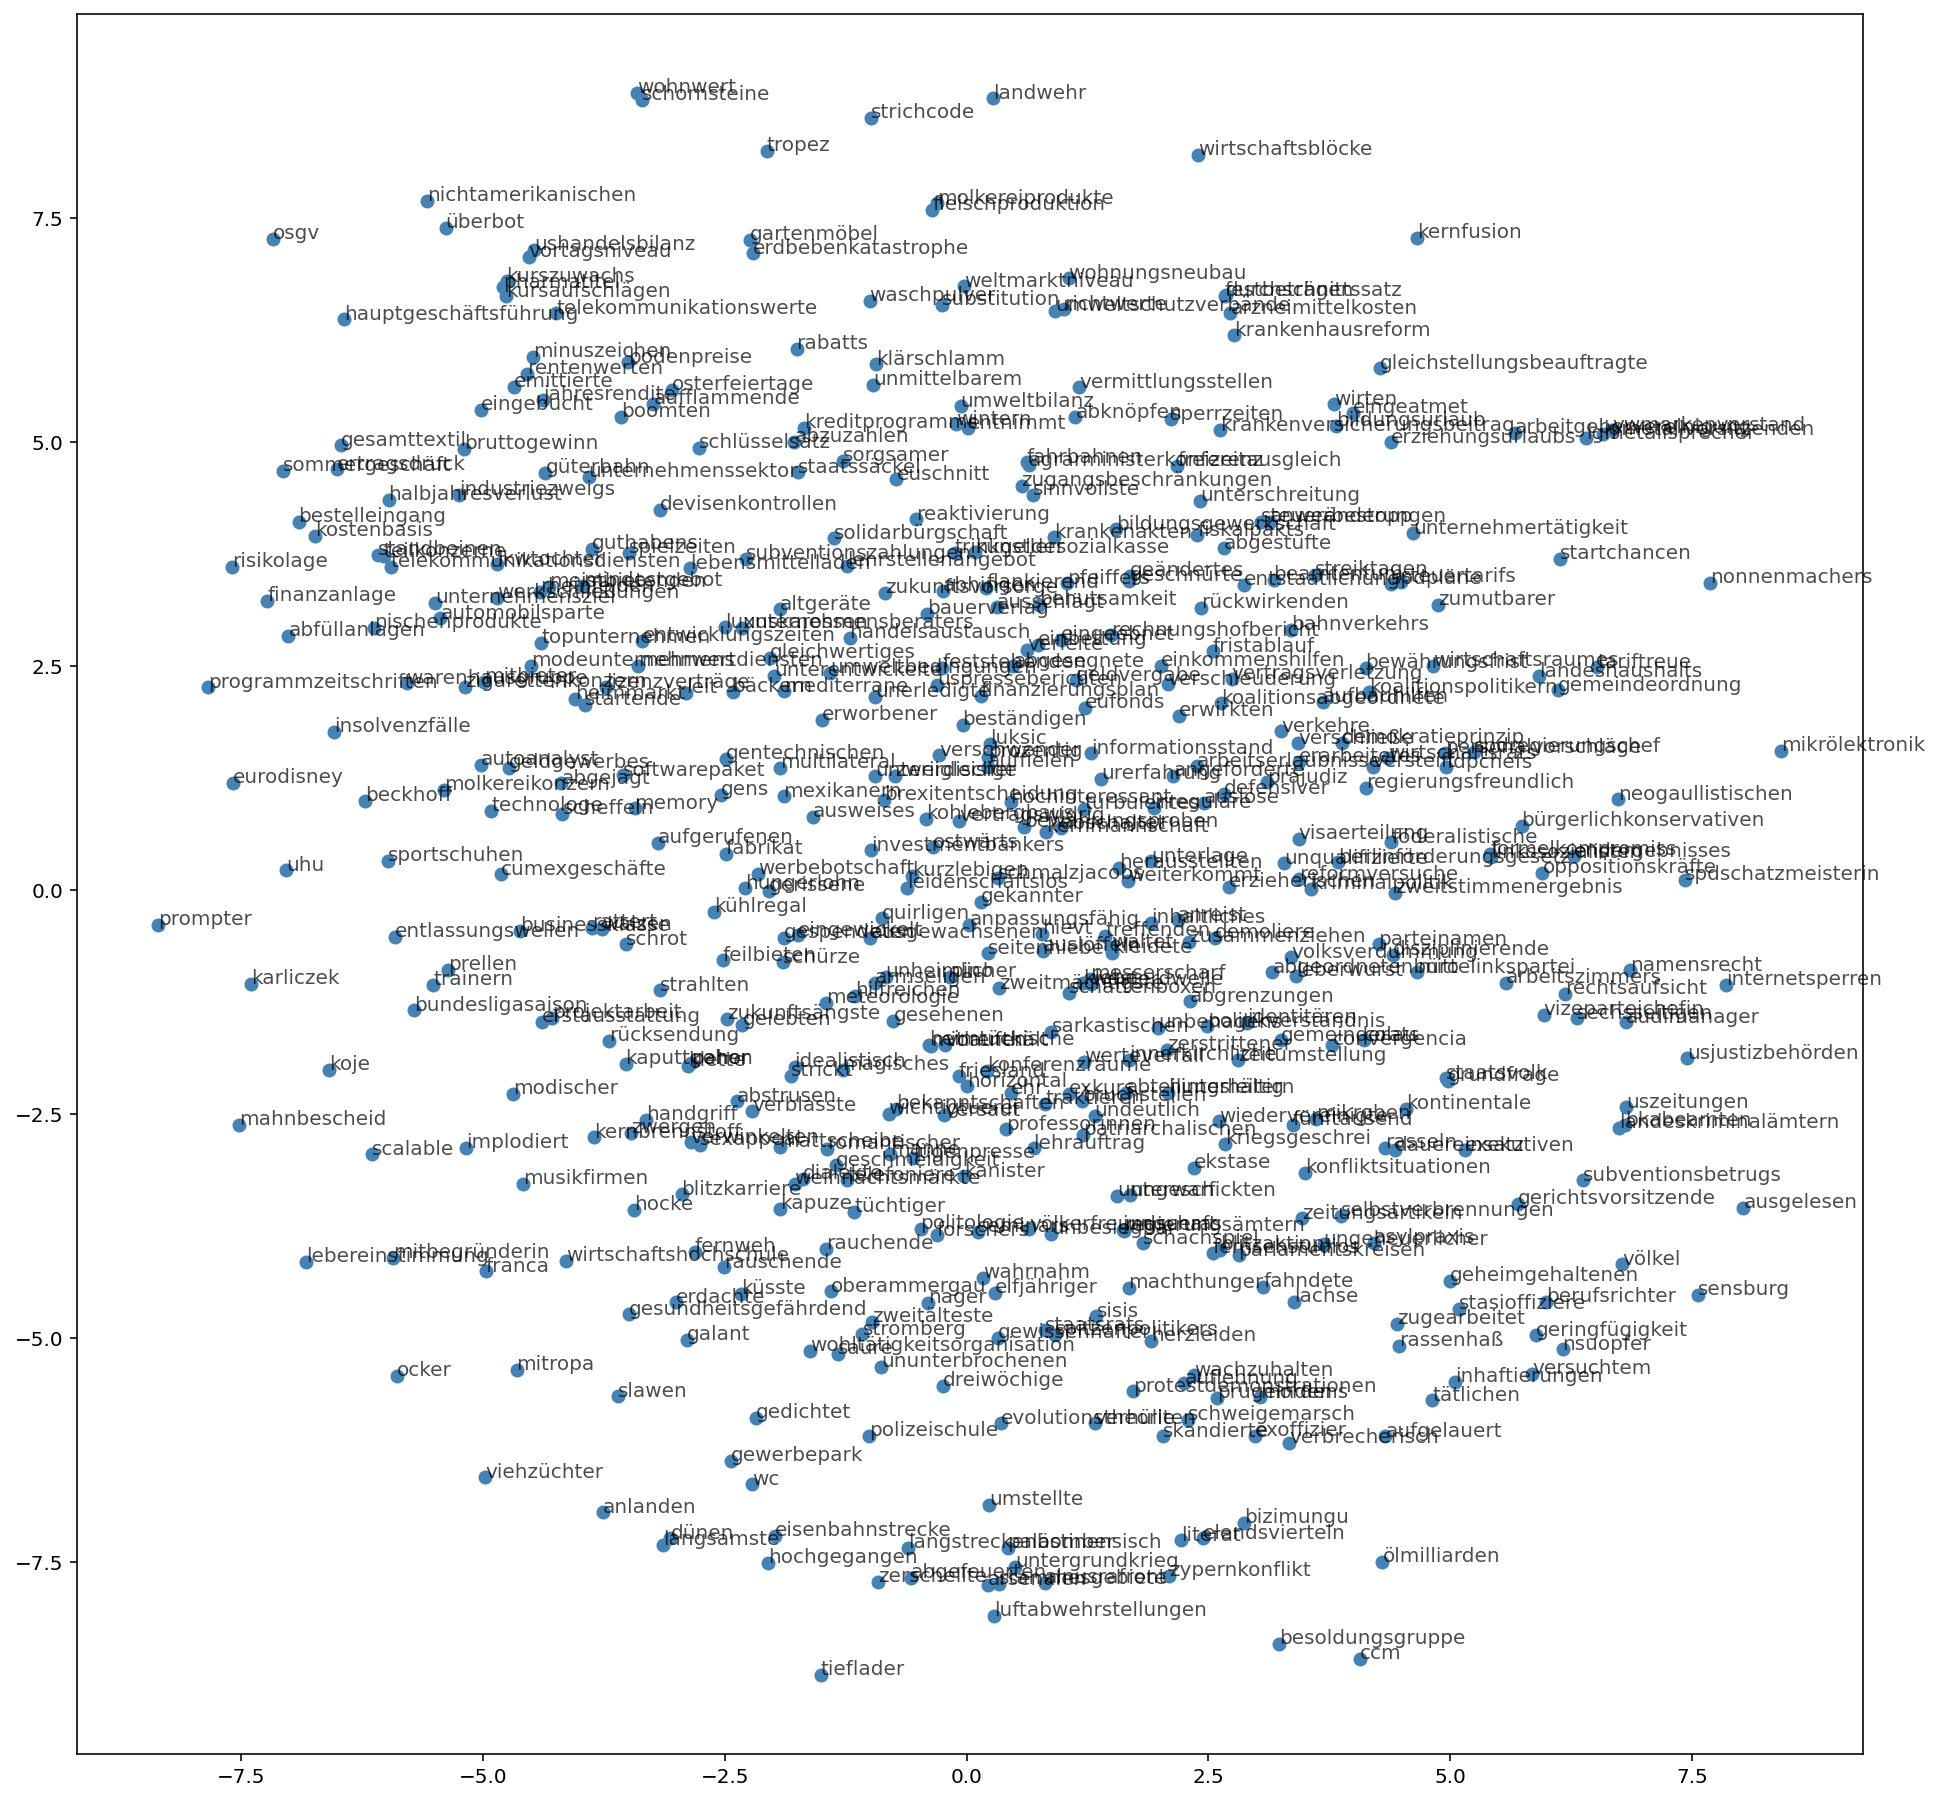

In [31]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words-89500):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx+89500], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

In [158]:
vocab_to_int['wirtschaft']

242

In [159]:
embed_vectors = embeddings
magnitudes =np.sqrt(np.square(embed_vectors).sum(axis=1))
#test_examples = np.array([6406, 2937, 40508, 1222, 946, 404, 2508, 348, 12555, 1180])
test_examples = np.array([242])
test_vectors = embed_vectors[test_examples]
similarities = np.matmul(test_vectors, np.transpose(embed_vectors))/magnitudes

In [160]:
closest_idxs = similarities.argsort(axis=1)[:,-1000:]

In [161]:
for ii, test_idx in enumerate(test_examples):
    closest_words = [int_to_vocab[idx] for idx in closest_idxs[ii][::-1][0:]]
    print(int_to_vocab[test_idx] + " | " + ', '.join(closest_words))

wirtschaft | wirtschaft, volkswirtschaft, wirtschaftliche, wirtschaftswachstum, wirtschaftspolitik, ökonomen, aufschwung, wirtschafts, politik, wirtschaftlichen, arbeitsmarkt, industrie, binnennachfrage, arbeitslosigkeit, konjunktur, strukturreformen, wettbewerbsfähigkeit, dynamik, finanzpolitik, wirtschaftsentwicklung, wirtschaftspolitische, ökonomischen, wirtschaftsforscher, arbeitsmarktes, konjunkturprogramme, weltwirtschaft, bdi, beschäftigung, wirtschaftsexperten, ökonomische, binnenkonjunktur, reformen, diht, wirtschaftsaufschwung, gesamtwirtschaftlichen, wirtschaftspolitischen, konjunkturprogramm, außenhandel, wirtschaftsforschung, handelskammertag, dihk, ifoinstituts, sorgen, privatwirtschaft, aufschwungs, exportweltmeister, arbeitslosenzahlen, exportwirtschaft, staatsverschuldung, massenarbeitslosigkeit, gesamtwirtschaftliche, sachverständigenrat, gesamtwirtschaft, lohnpolitik, konjunkturaufschwung, wirtschaftswachstums, marktwirtschaft, staatsquote, rezession, arbeitsmärkte, 

In [162]:
with codecs.open("wirtschaft_synonyms_window10.txt", "w", "utf-8") as f:
    for item in closest_words:
        f.write("%s\n" % item)

In [413]:
embed_vectors = embeddings
magnitudes =np.sqrt(np.square(embed_vectors).sum(axis=1))
test_examples = np.array([vocab_to_int['unsicherheit']])
without = np.array([vocab_to_int['verbesserung']])
plus = np.array([vocab_to_int['konjunktur']])
#test_vectors = embed_vectors[test_examples]-embed_vectors[without]
test_vectors = embed_vectors[test_examples]-embed_vectors[without]+embed_vectors[plus]
similarities = np.matmul(test_vectors, np.transpose(embed_vectors))/magnitudes

In [414]:
closest_idxs = similarities.argsort(axis=1)[:,-100:]

In [415]:
for ii, test_idx in enumerate(test_examples):
    closest_words = [int_to_vocab[idx] for idx in closest_idxs[ii][::-1][1:]]
    print(int_to_vocab[test_idx] + " without " + int_to_vocab[without[0]] + " | " + ', '.join(closest_words))

unsicherheit without verbesserung | unsicherheit, weltkonjunktur, aktienkurse, abschwung, finanzmärkten, rezession, euroraum, aktienmärkten, aufschwung, turbulenzen, leitzinsen, börsen, aktienmarkt, zinserhöhungen, börsianer, aktienmärkte, schuldenkrise, konjunkturdaten, eurokurs, weltwirtschaft, konjunkturaussichten, zinserhöhung, konjunkturelle, inflation, geldpolitik, uskonjunktur, furcht, uswirtschaft, unsicherheiten, finanzmärkte, erholung, eurokrise, ölpreise, ölpreis, euroschuldenkrise, anleger, notenbanken, usnotenbank, inflationsgefahr, deflation, geldschwemme, zinssenkung, nervosität, zinswende, kurse, konjunktureinbruch, nervös, konjunkturflaute, rohstoffpreise, konjunkturerholung, zinsen, euroschwäche, fallende, eurozone, verunsicherung, geldflut, kauflaune, zinssenkungen, wirtschaftsdaten, ifoindex, flaute, nachlassende, stimmung, unternehmensgewinne, dax, anziehenden, immobilienmarkt, fed, konjunkturellen, anhält, schwache, aktienbörsen, notenbanker, notenbank, anhaltend,

 # Draw only some embeddings

In [113]:
to_draw_int = np.array([vocab_to_int[word] for word in closest_words]) 
to_draw = embed_vectors[to_draw_int]

In [114]:
tsne = TSNE()
embed_tsne = tsne.fit_transform(to_draw[:100, :])

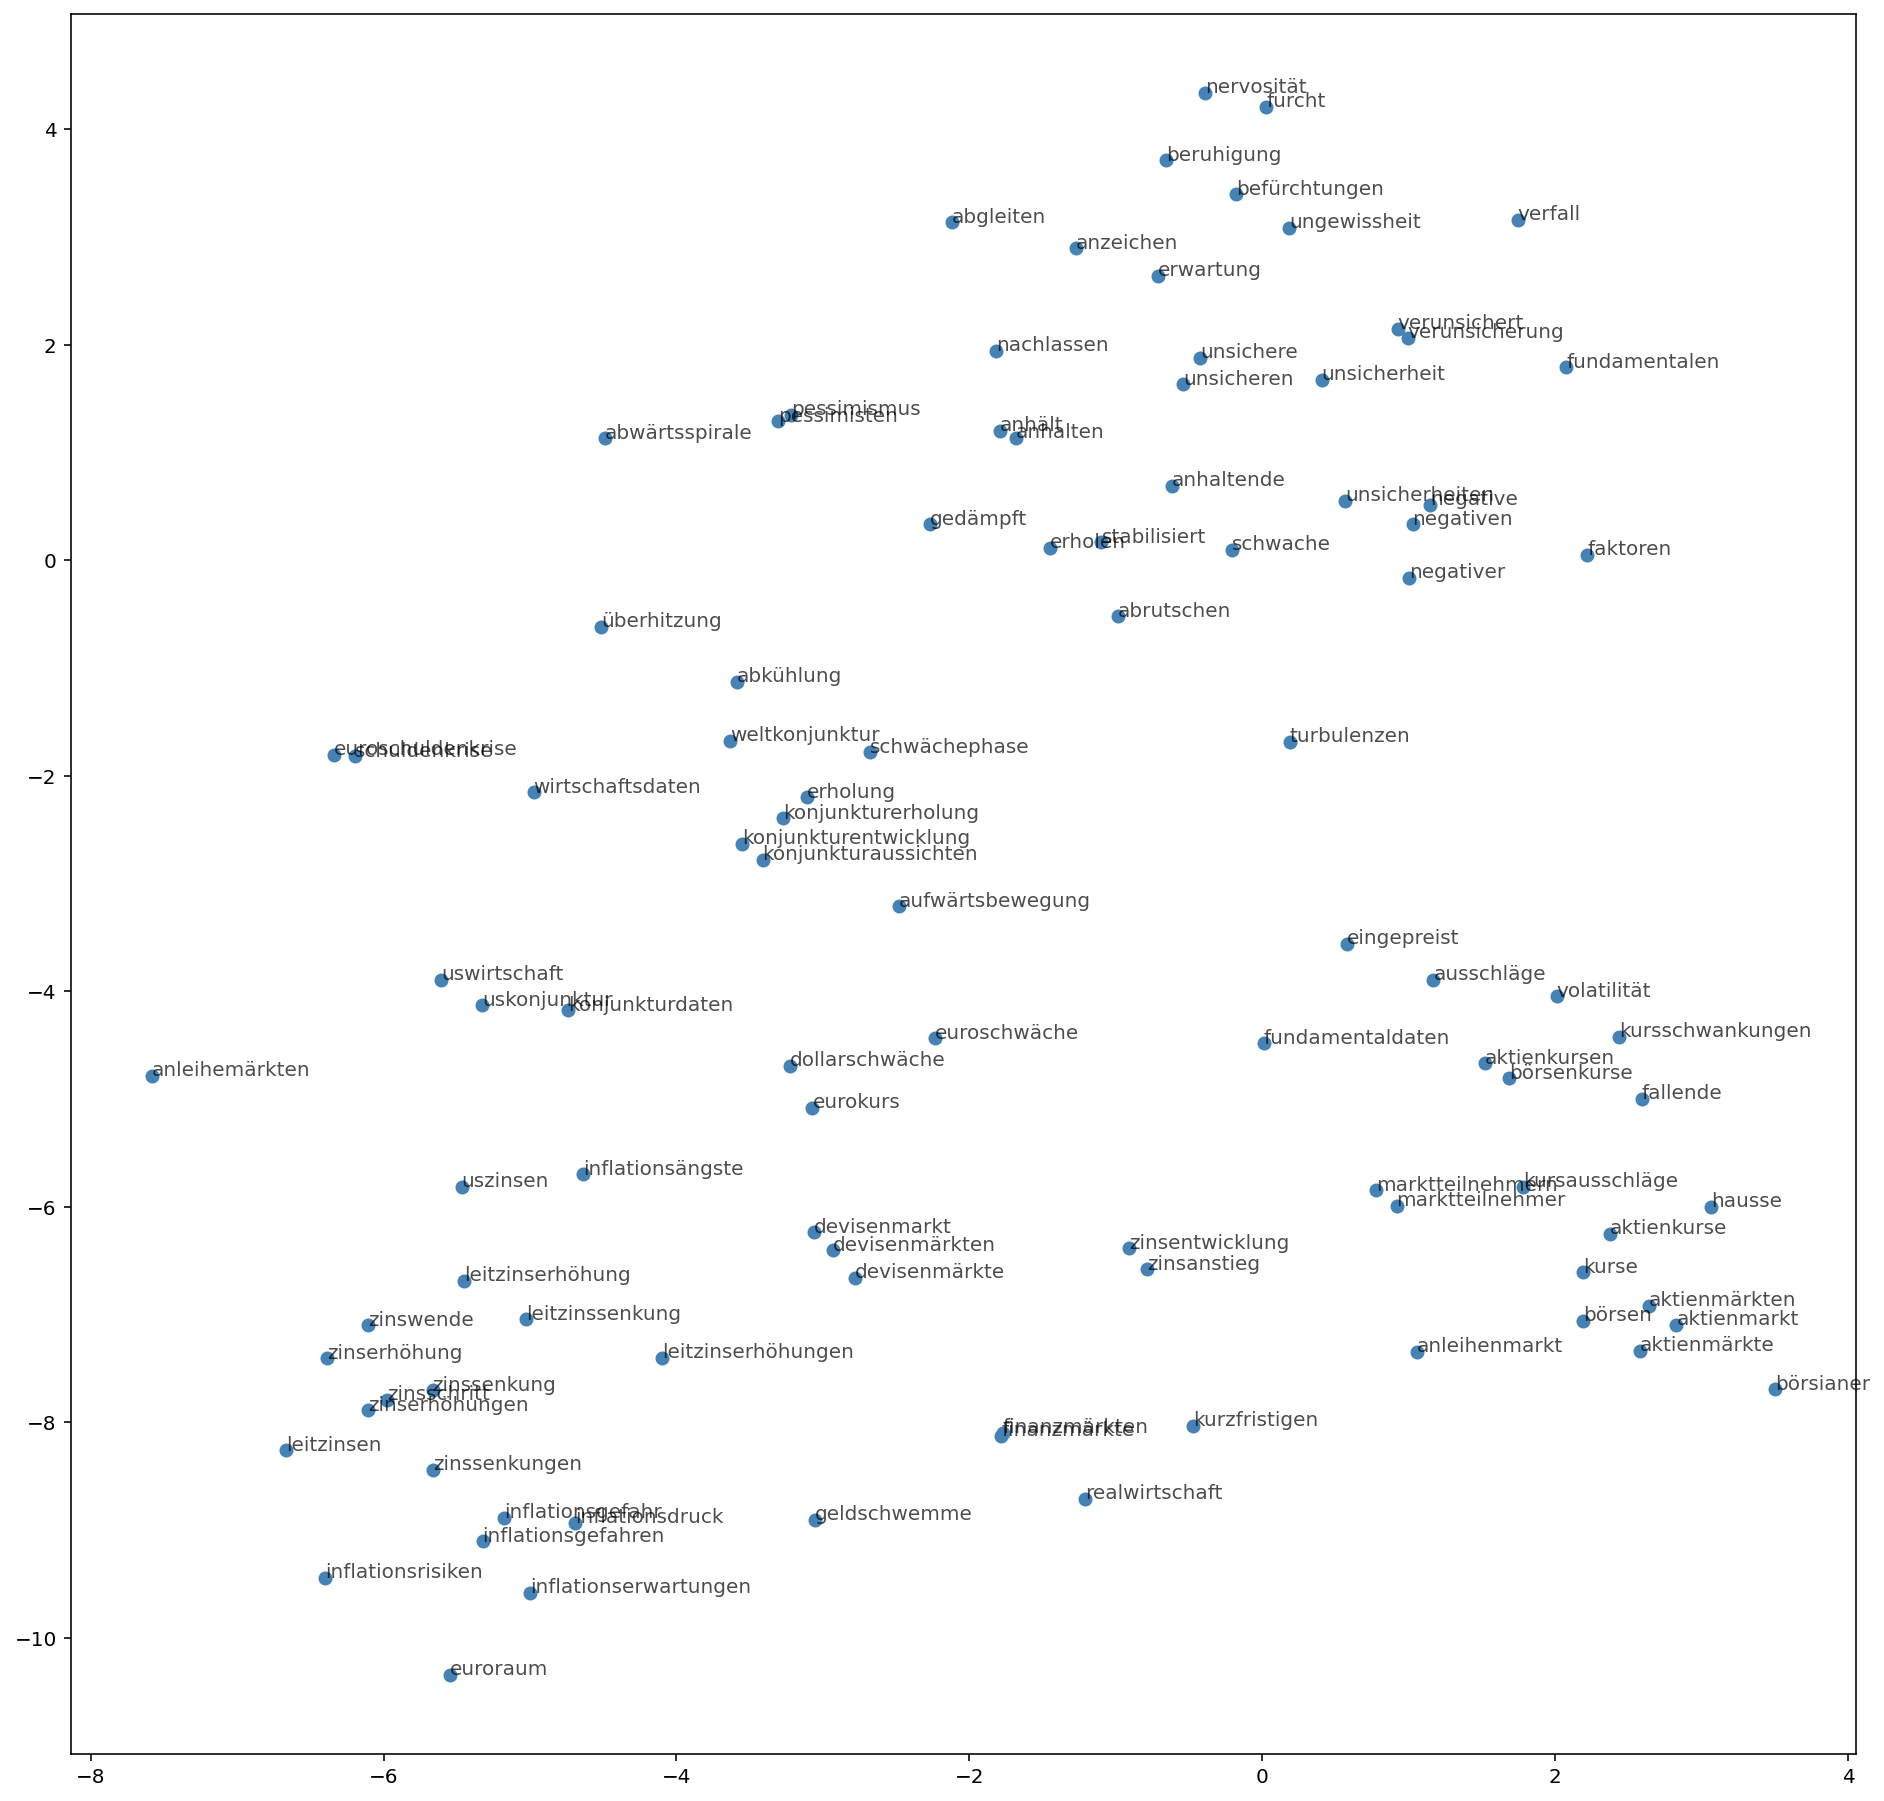

In [115]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(100):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[to_draw_int[idx]], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)